In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import matplotlib
from numba import njit 
import scienceplots
plt.style.use(['science'])
plt.rcParams.update({'font.size': 20, 'font.weight': 'bold', 'font.family': 'sans-serif'})

In [2]:
# euler maryuma for simulating a brownian gyrator
@njit
def brownian_gyrator(k, alpha, T, eta, ini, dt, nsteps):
    x = np.zeros(nsteps)
    y = np.zeros(nsteps)
    kx = k[0]
    ky = k[1]
    x[0] = ini[0]
    y[0] = ini[1]
    eta_x = eta[0]
    eta_y = eta[1]
    Tx = T[0]
    Ty = T[1]
    for i in range(1, nsteps):
        x[i] = x[i-1] + dt*(-1/eta_x)*(kx*(np.cos(alpha)*x[i-1] + ky*np.sin(alpha)*y[i-1])*np.cos(alpha) - ky*(np.cos(alpha)*y[i-1] - np.sin(alpha)*x[i-1])*np.sin(alpha)) + np.sqrt(2*Tx/eta_x)*np.random.normal(0, np.sqrt(dt))
        y[i] = y[i-1] + dt*(-1/eta_y)*(-kx*(np.cos(alpha)*x[i-1] + ky*np.sin(alpha)*y[i-1])*np.sin(alpha) + ky*(np.cos(alpha)*y[i-1] - np.sin(alpha)*x[i-1])*np.cos(alpha)) + np.sqrt(2*Ty/eta_y)*np.random.normal(0, np.sqrt(dt))
    
    return x, y

In [3]:
# new brownian gyrator with a constraint. 
@njit
def bgyrator(k,alpha,T,eta,ini,dt,nsteps):
    x = np.zeros((nsteps,2))
    A = np.zeros((2,2))
    B = np.zeros((2,2))
    A[0,0] = k/eta
    A[0,1] = alpha/eta
    A[1,0] = alpha/eta
    A[1,1] = k/eta
    
    B[0,0] = np.sqrt(2*T[0]/eta)
    B[1,1] = np.sqrt(2*T[1]/eta)
    
    x[0] = ini
    
    for i in range(1,nsteps):
        xi = np.random.normal(0,np.sqrt(dt),(2,))
        x[i] = x[i-1] - dt*(A @ x[i-1]) + B @ xi

    return x[:,0], x[:,1]

def velocity(x,y,dt):
    vx = np.diff(x)/dt
    vy = np.diff(y)/dt
    return vx, vy
    
    

In [4]:
# Underdamped brownian gyrator 
@njit
def ubgyrator(k,alpha,m,T,eta,ini,dt,nsteps):
    A = np.zeros((4,4))
    B = np.zeros((4,4))
    x = np.zeros((nsteps,4))
    A[0,2] = 1/m
    A[1,3] = 1/m
    A[2,0] = -k
    A[2,1] = -alpha
    A[2,2] = -eta/m
    A[3,0] = -alpha
    A[3,1] = -k
    A[3,3] = -eta/m
    B[2,2] = np.sqrt(2*T[0]*eta/m**2)
    B[3,3] = np.sqrt(2*T[1]*eta/m**2)
    x[0] = ini
    for i in range(1,nsteps):
        xi = np.random.normal(0,np.sqrt(dt),(4,))
        x[i] = x[i-1] + dt*(A @ x[i-1]) + B @ xi
    return x
# Define the potential function for the Brownian gyrator
def potentialbr(x, y, k, alpha):
    """
    Potential for Brownian gyrator: U(x,y) = (1/2)k(x² + y²) + αxy
    """
    return 0.5 * k * (x**2 + y**2) + alpha * x * y

# Generate potential contour data
def generate_potential_grid(k, alpha, x_range, y_range, n_points=100):
    """
    Generate grid for potential contour plot
    """
    x = np.linspace(x_range[0], x_range[1], n_points)
    y = np.linspace(y_range[0], y_range[1], n_points)
    X, Y = np.meshgrid(x, y)
    Z = potentialbr(X, Y, k, alpha)
    return X, Y, Z
def angularmomentum(trajectory):
    x = trajectory[:, 0]
    y = trajectory[:, 1]
    px = trajectory[:, 2]
    py = trajectory[:, 3]
    L = x*py - y*px
    return L

# @njit
def odangularmomentum(x,y,dt):
    vx = np.diff(x)/dt
    vy = np.diff(y)/dt
    L = x[:-1]*vy - y[:-1]*vx
    return L

def theoangularmomentum(k, u, eta, m, T):
    T1 = T[0]
    T2 = T[1]
    diffT = T2 - T1
    L = (eta*m*u*diffT)/(eta*k*eta + u*u*m )
    return L

In [5]:
# Underdamped brownian gyrator 
@njit
def ubgyrator_imp(k,u,m,T,eta,ini,dt,nsteps):
    F = np.zeros((4,4))
    B = np.zeros((4,4))
    x = np.zeros((nsteps,4))
    xt = np.zeros((nsteps,4))
    F[0,2] = k
    
    B[2,2] = np.sqrt(2*T[0]*eta/m**2)
    B[3,3] = np.sqrt(2*T[1]*eta/m**2)
    x[0] = ini
    alpha = 1-np.exp(-eta*dt)
    for i in range(1,nsteps):
        xi = np.random.normal(0,np.sqrt(dt),(4,))
        
        x[i] = x[i-1] - dt*(F @ x[i-1]) + B @ xi
    return x,F,B
    

In [8]:

%%time
ini = [1.0, 0.0]
k = 10.
alpha = 4.
T = [0.01, 50.0]
# T = [0,0]
eta = 1.0
dt = 0.001
nsteps = 5000
x,y = bgyrator(k, alpha, T,eta, ini, dt, nsteps)
L = odangularmomentum(x,y,dt)
np.mean(L)

CPU times: user 3.88 ms, sys: 82 μs, total: 3.96 ms
Wall time: 3.65 ms


np.float64(21.036042676321625)

In [9]:
Runs =1
Larr = np.zeros(Runs)
for i in range(Runs):
    x,y = bgyrator(k, alpha, T,eta, ini, dt, nsteps)
    L = odangularmomentum(x,y,dt)
    # print(f'Run {i+1}/{Runs}, L = {L[-1]}')
    Larr[i] = L[-1]


In [ ]:
T2 = np.linspace(T1, 50.0, 25)
T1 = 0.01
Runs = 1000
nsteps = int(2e5)
scut = 1000
# T = np.array([T1, T2])
avgl = np.zeros(len(T2))
stdl = np.zeros(len(T2))

stdx = np.zeros(len(T2))
stdvx = np.zeros(len(T2))
stdxvx = np.zeros(len(T2))
for i in range(len(T2)):
    T[1] = T2[i]
    x,y = bgyrator(k, alpha, T,eta, ini, dt, nsteps)
    vx, vy = velocity(x[scut:],y[scut:],dt)
    stdx[i] = np.std(x[scut:-1])
    stdvx[i] = np.std(vx)
    stdxvx[i] = stdx[i]*stdvx[i]
    # print(f'i = {i}')


In [11]:
# u[4:]

In [285]:
from scipy.optimize import curve_fit

def linfit(x,a,b):
    return a*x + b

popt1, pcov1 = curve_fit(linfit, u, avgl)
popt2, pcov2 = curve_fit(linfit, u, stdl)

popt1, popt2

(array([4.11591632, 1.63210211]), array([53.80443581, -0.39591893]))

In [286]:
(T[1]-T[0])/(k*eta)

4.9990000000000006

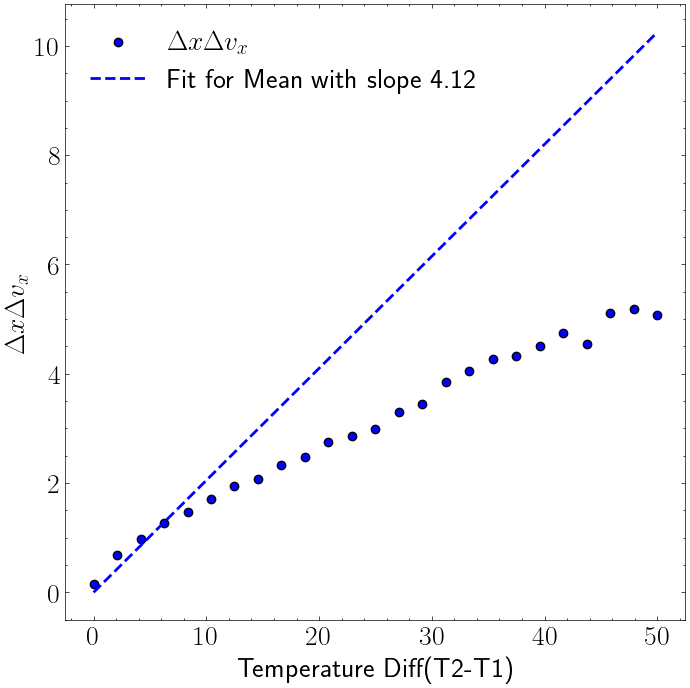

In [306]:
plt.figure(figsize=(8, 8))
plt.scatter(T2-T1,stdxvx, c='b', label=r"$\Delta x \Delta v_x$", edgecolor='k')
# plt.scatter(u, stdl, c='r', label='Std Dev of L', edgecolor='k')

plt.plot(T2-T1, linfit(T2-T1, 0.41,0)/2, 'b--', label=f'Fit for Mean with slope {popt1[0]:.2f}', lw = 2)
# plt.plot(u, linfit(u, *popt2), 'r--', label=f'Fit for Std Dev with slope {popt2[0]:.2f}', lw=2)
plt.xlabel('Temperature Diff(T2-T1)')
plt.ylabel(r'$\Delta x \Delta v_x$')
plt.legend()
# plt.title(r'L vs $k$ in Ovd Gyrator with theo. slope $(T_2-T_1)/(k\gamma)$='+str((T[1]-T[0])/(k*eta)))
# plt.savefig('images/odgyrator/L_vs_u_1.png', dpi=300)

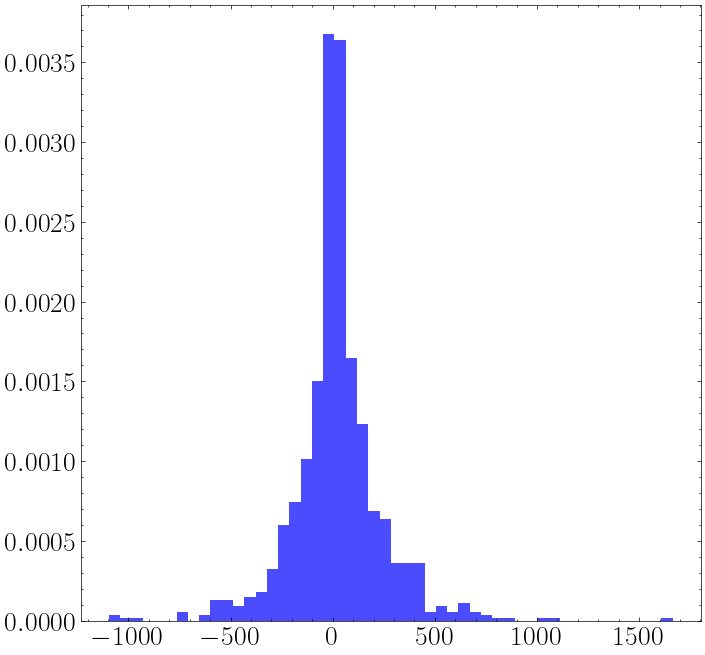

In [229]:
plt.figure(figsize=(8, 8))
plt.hist(Larr, bins=50, density=True, alpha=0.7, color='b');

In [230]:
np.mean(Larr),np.std(Larr),alpha/(k*eta) *(T[1]-T[0])

(np.float64(21.172061863253113),
 np.float64(221.67016111600367),
 19.996000000000002)

Text(0.5, 0, 'Time')

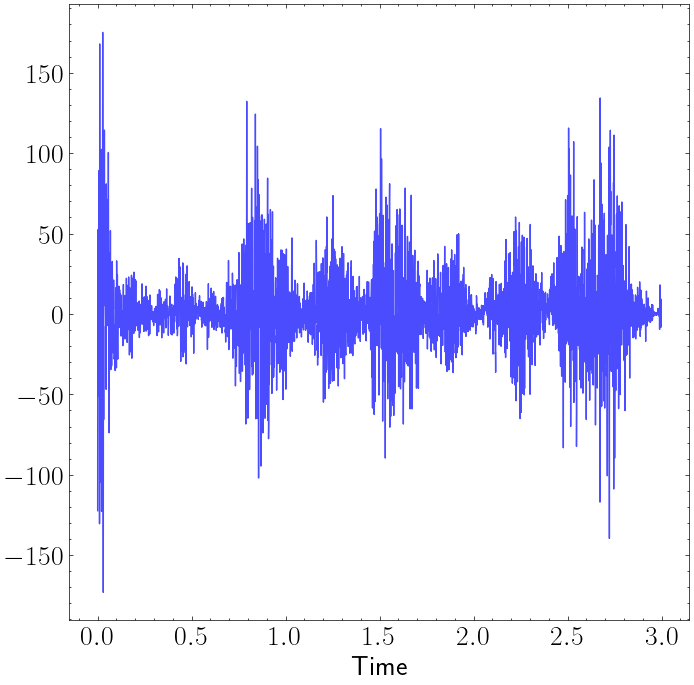

In [207]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(len(L))*dt, L, 'b-', alpha=0.7, lw=1, label='Angular Momentum')
plt.xlabel('Time')

In [34]:
%time
ini = [.0, 0.0, 1., 0.]
k = 10.0
m = 10.0
T = [0.0, 0.0]
eta = 1.0
alpha = 3.0
dt = 0.01
nsteps = 5000
trajectory = ubgyrator(k, alpha, m, T,eta, ini, dt, nsteps)
# ovd_trajectory = bgyrator(k, alpha, T, eta, ini2, dt, nsteps)


CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.72 μs


In [369]:
T2 = np.linspace(T1, 200.0, 200)
T1 = 0.01
Runs = 1000
nsteps = int(5e5)
scut = int(1e5)
T = np.asarray([T1, T2[0]])
# T = np.array([T1, T2])
avgl = np.zeros(len(T2))
stdl = np.zeros(len(T2))

stdx = np.zeros(len(T2))
stdy = np.zeros(len(T2))
stdvx = np.zeros(len(T2))
stdvy = np.zeros(len(T2))
stdxvx = np.zeros(len(T2))
stdyvy = np.zeros(len(T2)) 

stdxvy = np.zeros(len(T2))
stdyvx = np.zeros(len(T2))
 
stdxy = np.zeros(len(T2))
stdvxvy = np.zeros(len(T2))

for i in range(len(T2)):
    T[1] = T2[i]
    print(T[1]-T[0])
    trajectory = ubgyrator(k, alpha, m, T,eta, ini, dt, nsteps)
    x = trajectory[:,0]
    y = trajectory[:,1]
    vx = trajectory[:,2]
    vy = trajectory[:,3]
    stdx[i] = np.std(x[scut:-1])
    stdy[i] = np.std(y[scut:-1])
    stdvx[i] = np.std(vx[scut:])
    stdvy[i] = np.std(vy[scut:])
    stdxvx[i] = stdx[i]*stdvx[i]
    stdyvy[i] = stdy[i]*stdvy[i]
    
    stdxvy[i] = stdx[i]*stdvy[i]
    stdyvx[i] = stdy[i]*stdvx[i]
    
    stdxy[i] = stdx[i]*stdy[i]
    stdvxvy[i] = stdvx[i]*stdvy[i]
    
    print(f'i = {i}')

0.0
i = 0
1.0049748743718594
i = 1
2.009949748743719
i = 2
3.0149246231155784
i = 3
4.019899497487438
i = 4
5.024874371859297
i = 5
6.029849246231157
i = 6
7.034824120603016
i = 7
8.039798994974875
i = 8
9.044773869346734
i = 9
10.049748743718594
i = 10
11.054723618090453
i = 11
12.059698492462314
i = 12
13.064673366834173
i = 13
14.069648241206032
i = 14
15.074623115577891
i = 15
16.07959798994975
i = 16
17.08457286432161
i = 17
18.08954773869347
i = 18
19.09452261306533
i = 19
20.099497487437187
i = 20
21.104472361809048
i = 21
22.109447236180905
i = 22
23.114422110552766
i = 23
24.119396984924627
i = 24
25.124371859296485
i = 25
26.129346733668346
i = 26
27.134321608040203
i = 27
28.139296482412064
i = 28
29.14427135678392
i = 29
30.149246231155782
i = 30
31.15422110552764
i = 31
32.1591959798995
i = 32
33.16417085427136
i = 33
34.16914572864322
i = 34
35.174120603015076
i = 35
36.17909547738694
i = 36
37.1840703517588
i = 37
38.18904522613066
i = 38
39.19402010050251
i = 39
40.1989

In [370]:
Theolist = np.asarray([theoangularmomentum(k, alpha, eta, m, [T2[i],T1]) for i in range(len(T2))])
# Theolist

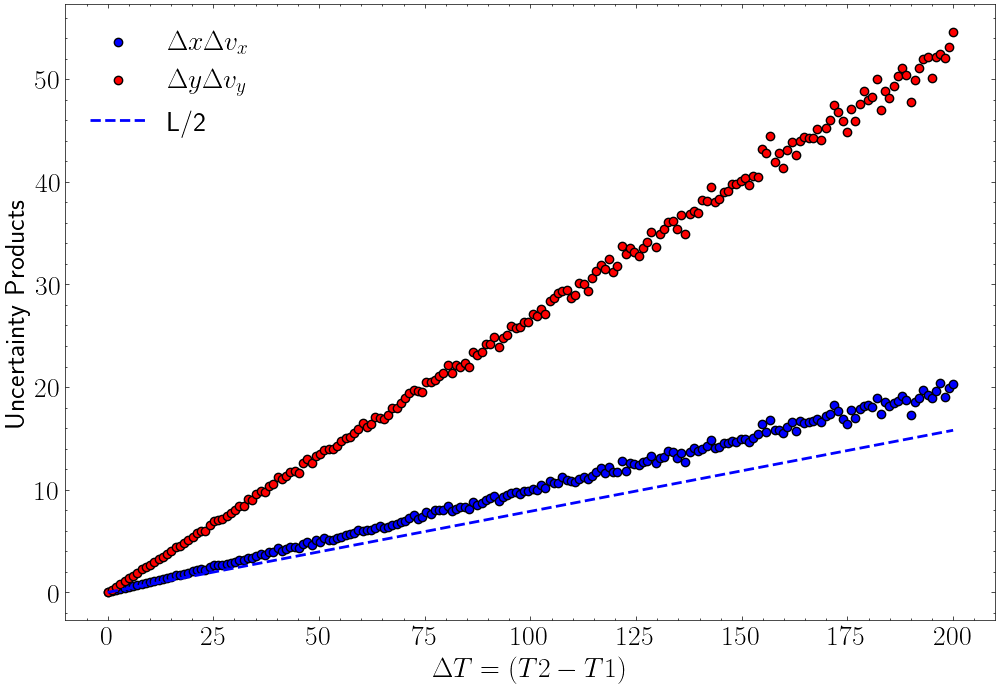

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(T2-T1,stdxvx, c='b', label=r"$\Delta x \Delta v_x$", edgecolor='k')
plt.scatter(T2-T1,stdyvy, c='r', label=r"$\Delta y \Delta v_y$", edgecolor='k')
# plt.scatter(T2-T1,stdxvy, c='g', label=r"$\Delta x \Delta v_y$", edgecolor='k')
# plt.scatter(T2-T1,stdyvx, c='m', label=r"$\Delta y \Delta v_x$", edgecolor='k')
# plt.scatter(T2-T1,stdxy, c='c', label=r"$\Delta x \Delta y$", edgecolor='k')
# plt.scatter(T2-T1,stdvxvy, c='y', label=r"$\Delta v_x \Delta v_y$", edgecolor='k')
# plt.scatter(u, stdl, c='r', label='Std Dev of L', edgecolor='k')

plt.plot(T2-T1, -Theolist/2, 'b--', label=f'L/2', lw = 2)
# plt.plot(u, linfit(u, *popt2), 'r--', label=f'Fit for Std Dev with slope {popt2[0]:.2f}', lw=2)
plt.xlabel(r'$\Delta T = (T2-T1)$')
plt.ylabel(r'Uncertainty Products')
plt.legend()
# plt.savefig('images/gyrator/uncertainty.png', dpi=300)

In [92]:
# Determine plot limits based on trajectory with some padding
x_min, x_max = trajectory[:, 0].min(), trajectory[:, 0].max()
y_min, y_max = trajectory[:, 1].min(), trajectory[:, 1].max()
padding = 0.06
x_range = (x_min - 2*padding, x_max + 2*padding)
y_range = (y_min - padding, y_max + padding)

# Generate potential contour data
X, Y, Z = generate_potential_grid(k, alpha, x_range, y_range, n_points=200)

Text(0.5, 1.0, 'Trajectory with parameters: $k=$10, $\\alpha=$2.0, $m=$1.0, $T_x=$0.01, $T_y=$100.0, $\\eta=$1.0')

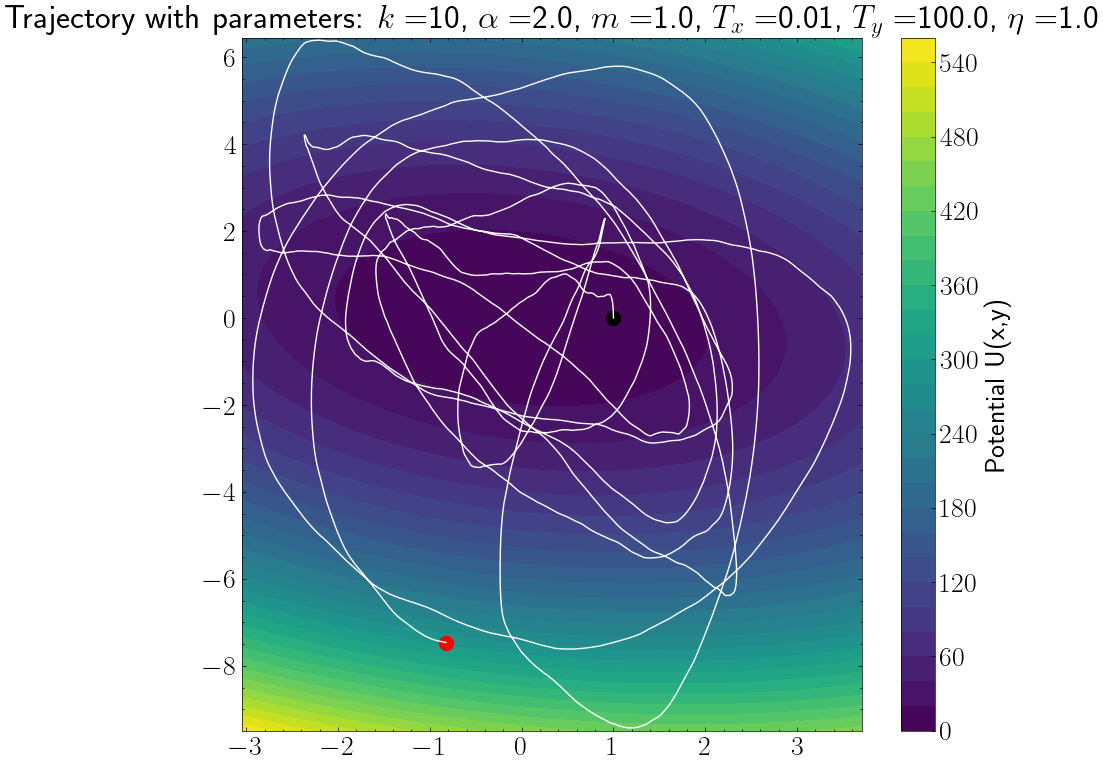

In [66]:
plt.figure(figsize=(10, 9))
contour = plt.contourf(X, Y, Z, levels=30, cmap='viridis')
plt.colorbar(contour, label='Potential U(x,y)')
plt.plot(trajectory[:, 0], trajectory[:, 1], color='white', lw=1)
plt.scatter(trajectory[0, 0], trajectory[0, 1], color='black', s=100, label='Start')
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', s=100, label='End')
plt.title(r'Trajectory with parameters: $k=$'+str(k)+r', $\alpha=$'+str(alpha)+r', $m=$'+str(m)+r', $T_x=$'+str(T[0])+r', $T_y=$'+str(T[1])+r', $\eta=$'+str(eta))
# plt.savefig("images/gyrator/udgyrator_trajectory_DTlarge_5_long.png", dpi=300)

In [ ]:
%time
ini = [.0, 1.0, 1., 0.]
k = 10.0
m = 1.0
T = [200.0, 0.01]
eta = 1.0
alpha = 4.0
dt = 0.001
nsteps = 10000
# trajectory = ubgyrator(k, alpha, m, T,eta, ini, dt, nsteps)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.44 μs


[   4    5    6 ... 7487 7488 7489]
[ -1.          -1.79694852  -0.94750166 ... -52.500184   -51.07806676
 -51.15765297] -30.767692307692307


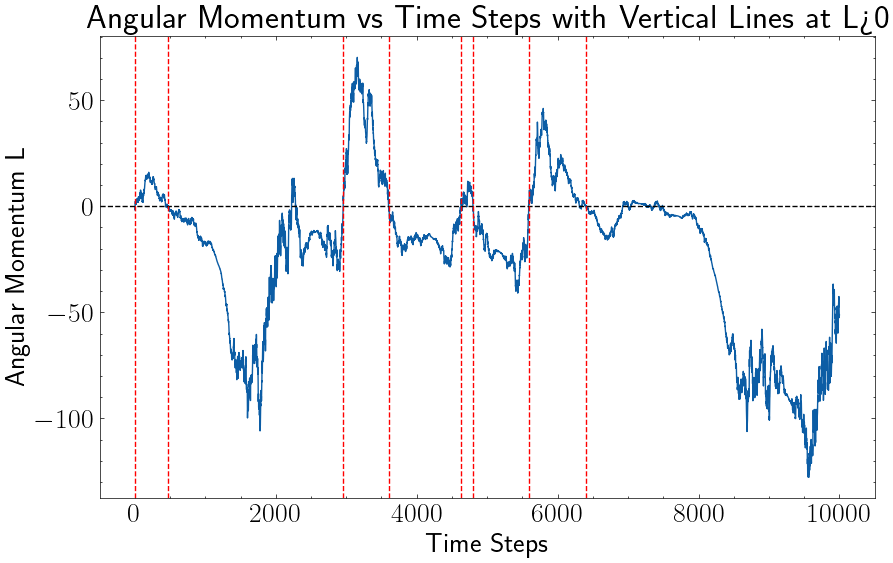

In [133]:
x = trajectory[:, 0]
y = trajectory[:, 1]
px = trajectory[:, 2]
py = trajectory[:, 3]

L = x*py - y*px
ind_l = np.where(L>0)[0]
print(ind_l)
lt = theoangularmomentum(k, alpha, eta, m, T)
print(L,lt)
plt.figure(figsize=(10, 6))
plt.plot(L)
plt.axhline(0, color='k', ls='--')
plt.axvline(4, color='r', ls='--')
plt.axvline(477, color='r', ls='--')


plt.axvline(2957, color='r', ls='--')
plt.axvline(3601, color='r', ls='--')
plt.axvline(4628, color='r', ls='--')
plt.axvline(4798, color='r', ls='--')
plt.axvline(5590, color='r', ls='--')
plt.axvline(6404, color='r', ls='--')
plt.xlabel('Time Steps')
plt.ylabel('Angular Momentum L')
plt.title('Angular Momentum vs Time Steps with Vertical Lines at L>0')
plt.savefig("images/odgyrator/udgyrator_L_vs_time_5_segs.png", dpi=300)




[ 477 2225 2226 ... 7487 7488 7489]


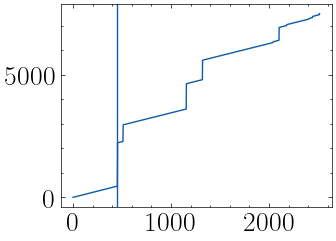

In [132]:
t = 453
print(ind_l[t:])
plt.plot(ind_l)
plt.axvline(t)

In [ ]:
## 2957-> 3601, 4628

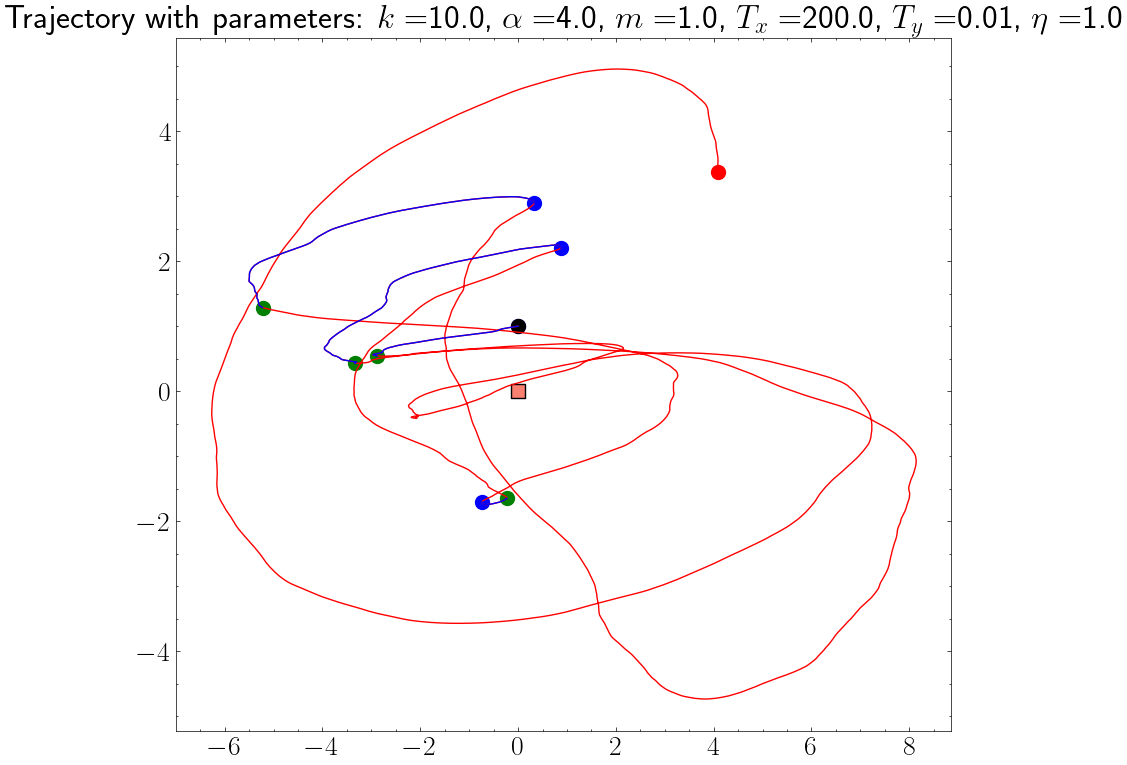

In [139]:
plt.figure(figsize=(10, 9))
# contour = plt.contourf(X, Y, Z, levels=30, cmap='viridis')
# plt.colorbar(contour, label='Potential U(x,y)')
plt.plot(trajectory[:, 0], trajectory[:, 1], color='r', lw=1)

plt.scatter(0,0, marker='s', color='salmon', s=100, label='Origin', edgecolor='k')

plt.plot(trajectory[4:477, 0], trajectory[4:477, 1], color='b', lw=1)
plt.scatter(trajectory[4, 0], trajectory[4, 1], color='b', s=100, label='Segment Start')
plt.scatter(trajectory[477, 0], trajectory[477, 1], color='g', s=100, label='Segment End')

plt.plot(trajectory[2957:3601, 0], trajectory[2957:3601, 1], color='b', lw=1)
plt.scatter(trajectory[2957, 0], trajectory[2957, 1], color='b', s=100, label='Segment Start')
plt.scatter(trajectory[3601, 0], trajectory[3601, 1], color='g', s=100, label='Segment End')

plt.plot(trajectory[4628:4798, 0], trajectory[4628:4798, 1], color='b', lw=1)
plt.scatter(trajectory[4628, 0], trajectory[4628, 1], color='b', s=100, label='Segment Start')
plt.scatter(trajectory[4798, 0], trajectory[4798, 1], color='g', s=100, label='Segment End')

plt.plot(trajectory[5590:6404, 0], trajectory[5590:6404, 1], color='b', lw=1)
plt.scatter(trajectory[5590, 0], trajectory[5590, 1], color='b', s=100, label='Segment Start')
plt.scatter(trajectory[6404, 0], trajectory[6404, 1], color='g', s=100, label='Segment End')

plt.scatter(trajectory[0, 0], trajectory[0, 1], color='black', s=100, label='Start')
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', s=100, label='End')
plt.title(r'Trajectory with parameters: $k=$'+str(k)+r', $\alpha=$'+str(alpha)+r', $m=$'+str(m)+r', $T_x=$'+str(T[0])+r', $T_y=$'+str(T[1])+r', $\eta=$'+str(eta))
plt.savefig("images/odgyrator/udgyrator_trajectory_5_segs.png", dpi=300)

In [27]:

# Create the figure and axis
print("\nGenerating simple animation...")
fig_simple, ax = plt.subplots(1,2,figsize=(20, 9))
ax_simple = ax[0]
ax_simple.set_xlim(x.min() - 0.05, x.max() + 0.05)
ax_simple.set_ylim(y.min() - 0.05, y.max() + 0.05)
ax_simple.set_xlabel('x position')
ax_simple.set_ylabel('y position')
# contour_lines_simple = ax_simple.contourf(X, Y, Z, levels=30, cmap='viridis')
ax_simple.set_title('Brownian Gyrator Trajectory Animation')
ax_simple.grid(True, alpha=0.3)
ax_simple.set_aspect('equal', adjustable='datalim')

line, = ax_simple.plot([], [], 'b-', alpha=0.7, lw=1)
point, = ax_simple.plot([], [], 'ro', markersize=8)

axes = ax[1]
line1, = axes.plot([], [], 'b-', alpha=0.7, lw=1)
axes.set_xlim(0, nsteps*dt)
axes.set_ylim(L.min() - 0.05, L.max() + 0.05)
axes.set_xlabel('Time')
axes.set_ylabel('Angular Momentum L')
axes.set_title('Angular Momentum vs Time')

def update_simple(frame):
    line.set_data(x[:frame+1], y[:frame+1])
    point.set_data([x[frame]], [y[frame]])
    line1.set_data(np.arange(0, (frame+1)*dt, dt), L[:frame+1])
    # ax_simple.set_title(f'Brownian Gyrator Trajectory\nTime: {time[frame]:.2f}, Step: {frame}')
    print(f'Frame {frame+1}/{nsteps/1}')
    return line, point, line1

ani_simple = FuncAnimation(fig_simple, update_simple, frames=int(nsteps/10), interval=10, blit=True)
ani_simple.save('images/odgyrator/bg_test1.mp4', writer='ffmpeg', dpi=300)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.



Generating simple animation...
Frame 1/20000.0
Frame 1/20000.0
Frame 1/20000.0
Frame 1/20000.0
Frame 2/20000.0
Frame 3/20000.0
Frame 4/20000.0
Frame 5/20000.0
Frame 6/20000.0
Frame 7/20000.0
Frame 8/20000.0
Frame 9/20000.0
Frame 10/20000.0
Frame 11/20000.0
Frame 12/20000.0
Frame 13/20000.0
Frame 14/20000.0
Frame 15/20000.0
Frame 16/20000.0
Frame 17/20000.0
Frame 18/20000.0
Frame 19/20000.0
Frame 20/20000.0
Frame 21/20000.0
Frame 22/20000.0
Frame 23/20000.0
Frame 24/20000.0
Frame 25/20000.0
Frame 26/20000.0
Frame 27/20000.0
Frame 28/20000.0
Frame 29/20000.0
Frame 30/20000.0
Frame 31/20000.0
Frame 32/20000.0
Frame 33/20000.0
Frame 34/20000.0
Frame 35/20000.0
Frame 36/20000.0
Frame 37/20000.0
Frame 38/20000.0
Frame 39/20000.0
Frame 40/20000.0
Frame 41/20000.0
Frame 42/20000.0
Frame 43/20000.0
Frame 44/20000.0
Frame 45/20000.0
Frame 46/20000.0
Frame 47/20000.0
Frame 48/20000.0
Frame 49/20000.0
Frame 50/20000.0
Frame 51/20000.0
Frame 52/20000.0
Frame 53/20000.0
Frame 54/20000.0
Frame 55/20

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1002,) and arg 1 with shape (1001,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1002,) and arg 1 with shape (1001,).

<Figure size 2000x900 with 2 Axes>

In [93]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("Z shape:", Z.shape)


X shape: (200, 200)
Y shape: (200, 200)
Z shape: (200, 200)


Text(0.5, 0.98, 'Phase plots with parameters: $k=$10.0, $\\alpha=$3.0, $m=$1.0, $T_x=$100.0, $T_y=$1.0, $\\eta=$1.0')

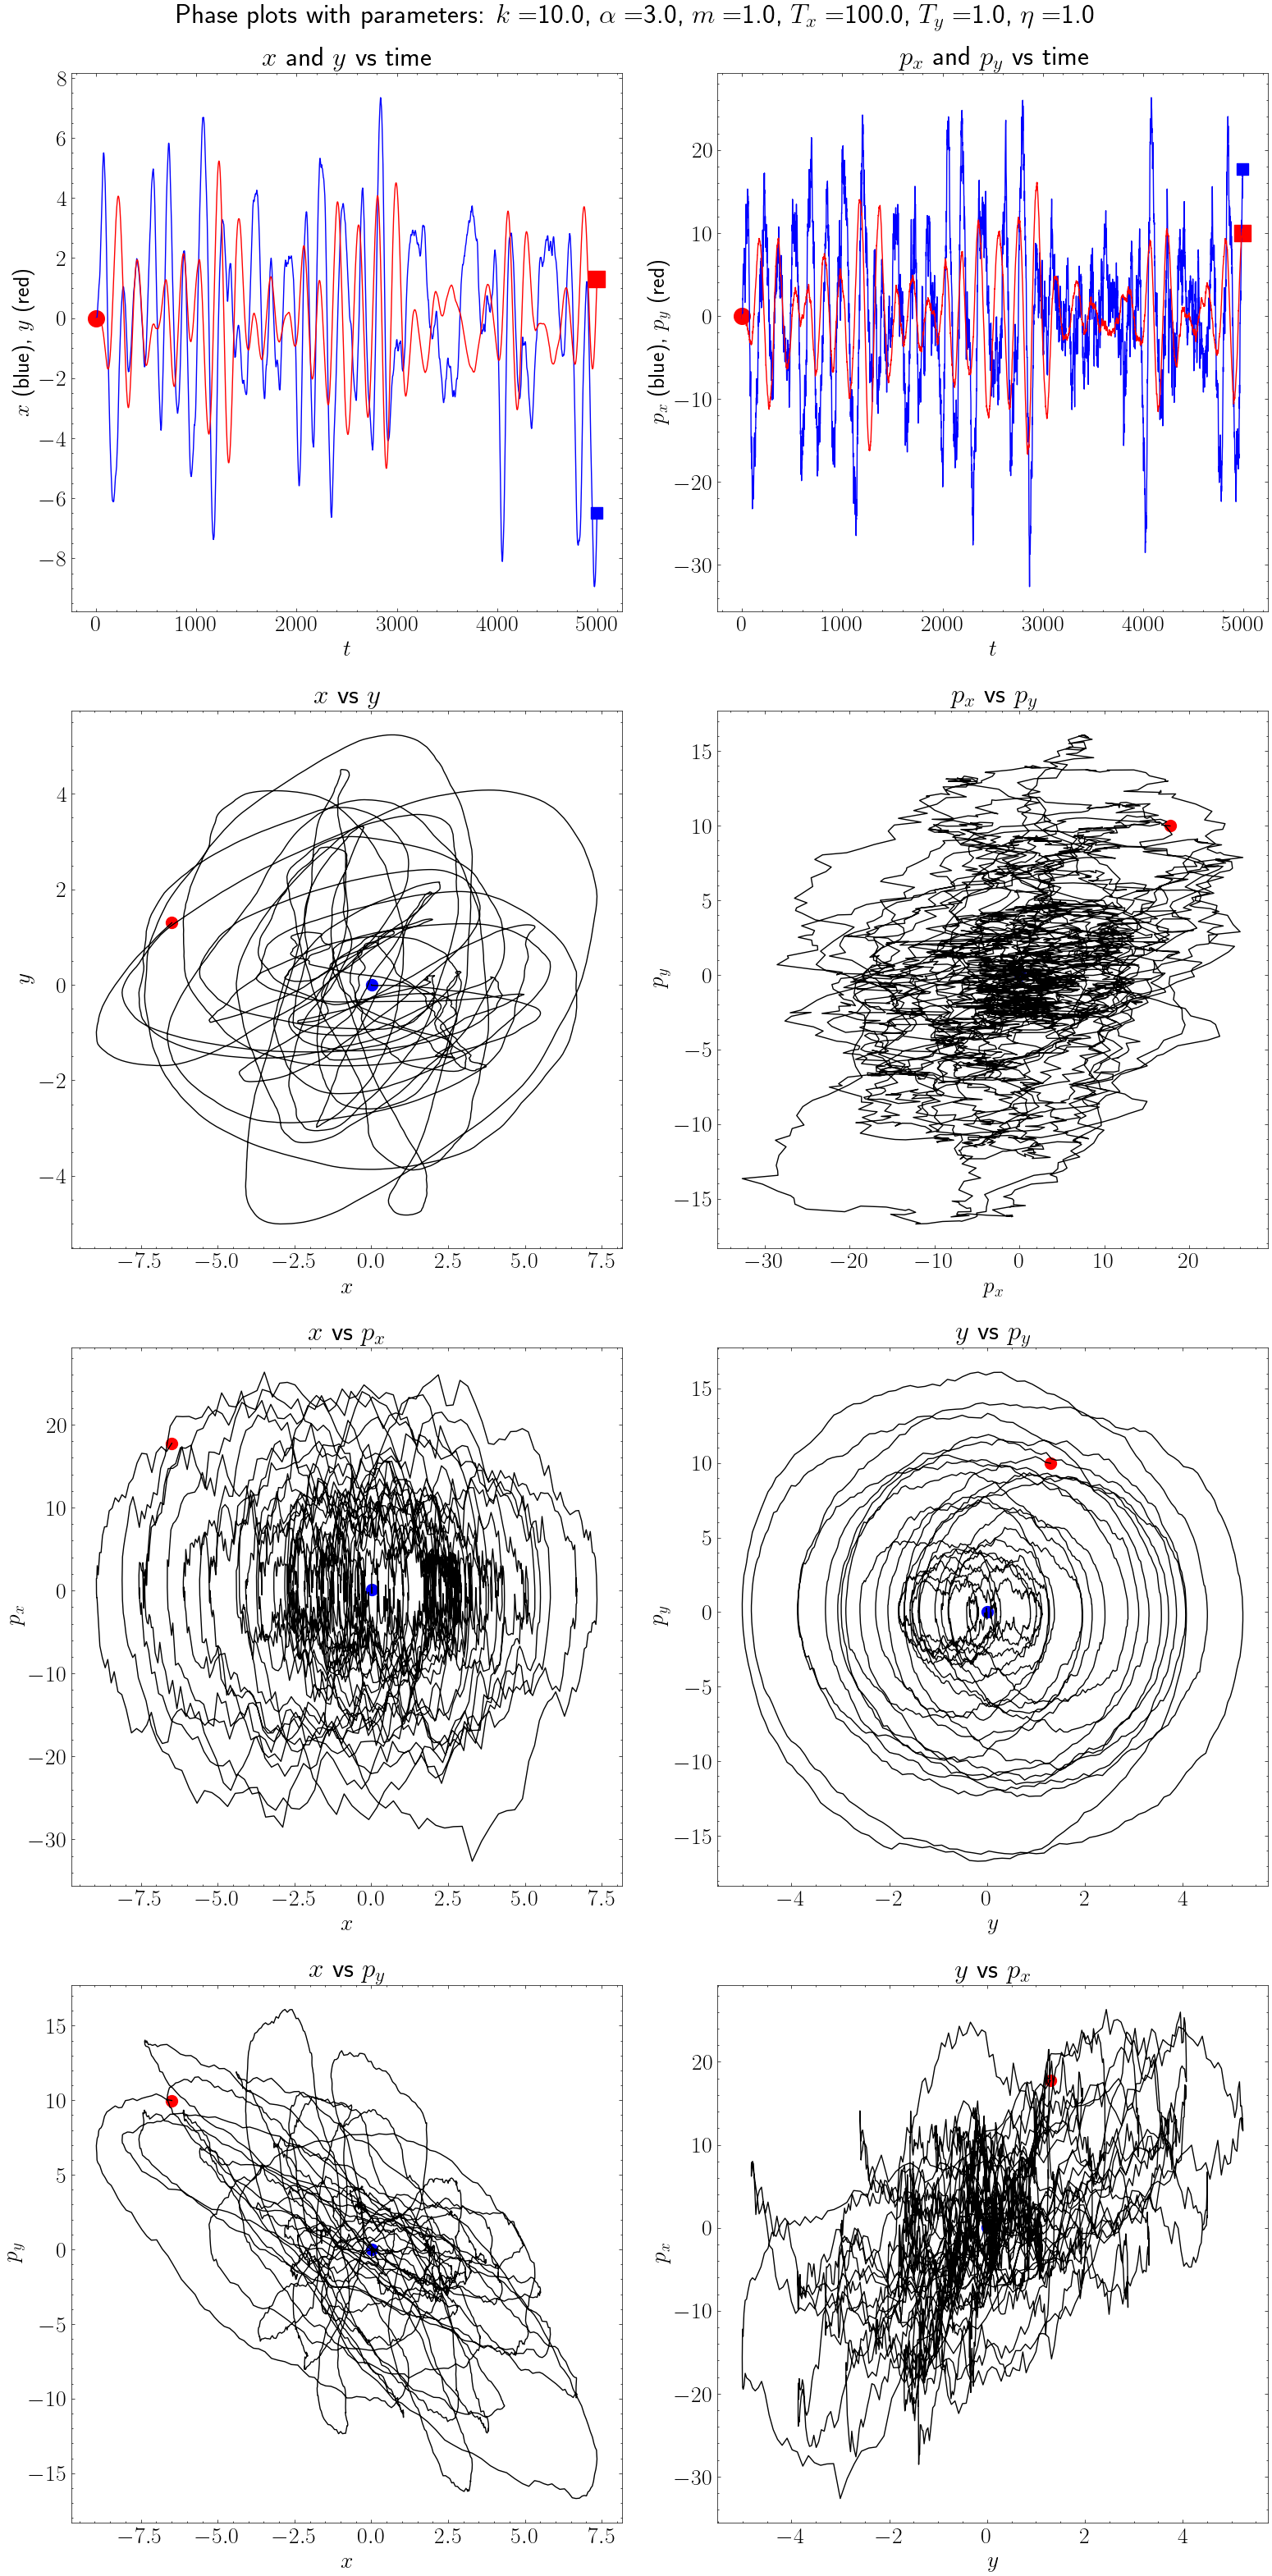

In [100]:
fig,axes = plt.subplots(4,2,figsize=(16,32), tight_layout=True)

ax = axes[0,0]
ax.plot(np.arange(0,nsteps), trajectory[:, 0], color='b', lw=1)
ax.plot(np.arange(0,nsteps), trajectory[:, 1], color='r', lw=1)
ax.scatter(0, trajectory[0, 0], color='b', s=100, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 0], marker='s',color='b', s=100, label='End')
ax.scatter(0, trajectory[0, 1], color='r', s=200, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 1],marker='s', color='r', s=200, label='End')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$ (blue), $y$ (red)')
ax.set_title(r'$x$ and $y$ vs time')

ax = axes[0,1]
ax.plot(np.arange(0,nsteps), trajectory[:, 2], color='b', lw=1)
ax.plot(np.arange(0,nsteps), trajectory[:, 3], color='r', lw=1)
ax.scatter(0, trajectory[0, 2], color='b', s=100, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 2],marker='s', color='b', s=100, label='End')
ax.scatter(0, trajectory[0, 3], color='r', s=200, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 3],marker='s', color='r', s=200, label='End')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$p_x$ (blue), $p_y$ (red)')
ax.set_title(r'$p_x$ and $p_y$ vs time')

ax = axes[1,0]
ax.plot( trajectory[:, 0], trajectory[:, 1], color='k', lw=1)
ax.scatter(trajectory[0, 0], trajectory[0, 1], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 0], trajectory[-1, 1], color='r', s=100, label='End')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'$x$ vs $y$')

ax = axes[1,1]
ax.plot( trajectory[:, 2], trajectory[:, 3], color='k', lw=1)
ax.scatter(trajectory[0, 2], trajectory[0, 3], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 2], trajectory[-1, 3], color='r', s=100, label='End')
ax.set_xlabel(r'$p_x$')
ax.set_ylabel(r'$p_y$')
ax.set_title(r'$p_x$ vs $p_y$')

ax = axes[2,0]
ax.plot( trajectory[:, 0], trajectory[:, 2], color='k', lw=1)
ax.scatter(trajectory[0, 0], trajectory[0, 2], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 0], trajectory[-1, 2], color='r', s=100, label='End')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_title(r'$x$ vs $p_x$')

ax = axes[2,1]
ax.plot( trajectory[:, 1], trajectory[:, 3], color='k', lw=1)
ax.scatter(trajectory[0, 1], trajectory[0, 3], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 1], trajectory[-1, 3], color='r', s=100, label='End')
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$p_y$')
ax.set_title(r'$y$ vs $p_y$')

ax = axes[3,0]
ax.plot( trajectory[:, 0], trajectory[:, 3], color='k', lw=1)
ax.scatter(trajectory[0, 0], trajectory[0, 3], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 0], trajectory[-1, 3], color='r', s=100, label='End')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_y$')
ax.set_title(r'$x$ vs $p_y$')


ax = axes[3,1]
ax.plot( trajectory[:, 1], trajectory[:, 2], color='k', lw=1)
ax.scatter(trajectory[0, 1], trajectory[0, 2], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 1], trajectory[-1, 2], color='r', s=100, label='End')
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$p_x$')
ax.set_title(r'$y$ vs $p_x$')

fig.suptitle(r'Phase plots with parameters: $k=$'+str(k)+r', $\alpha=$'+str(alpha)+r', $m=$'+str(m)+r', $T_x=$'+str(T[0])+r', $T_y=$'+str(T[1])+r', $\eta=$'+str(eta), verticalalignment='baseline', fontsize=24)

# fig.savefig('images/gyrator/udgyrator_phase_DTlarge_5_long.png', dpi=300)

Text(0.5, 1.0, '$x$ vs $p_y$')

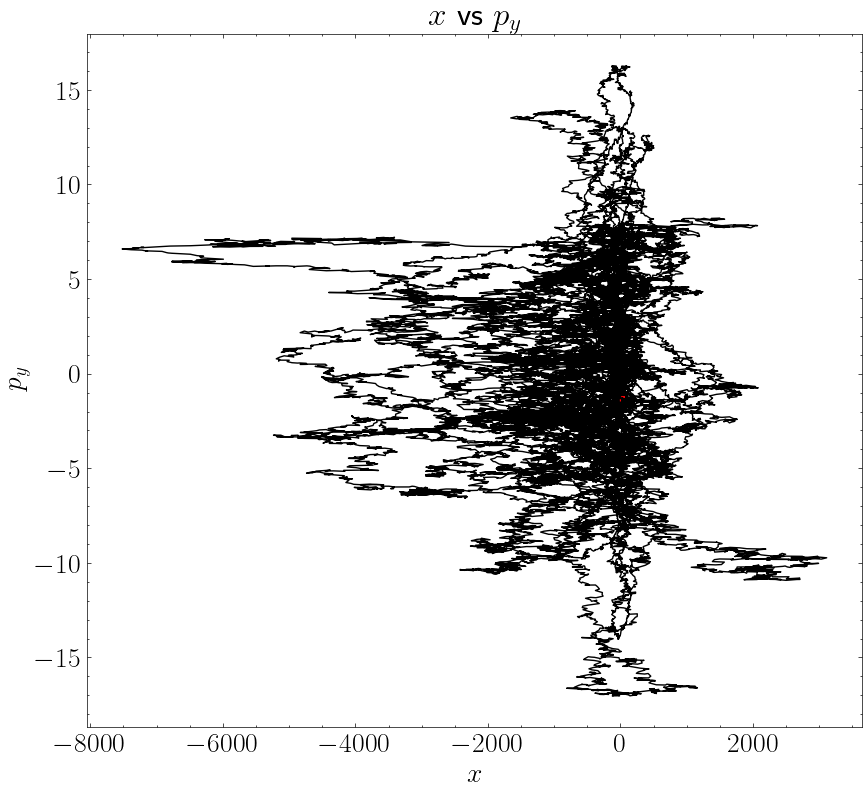

In [74]:
fig,ax = plt.subplots(figsize=(10,9))

ax.plot( xtraj - ytraj * pxtraj, trajectory[:, 3], color='k', lw=1)
ax.scatter(trajectory[0, 0], trajectory[0, 3], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 0], trajectory[-1, 3], color='r', s=100, label='End')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_y$')
ax.set_title(r'$x$ vs $p_y$')



In [58]:
xtraj = trajectory[:, 0]
ytraj = trajectory[:, 1]
pxtraj = trajectory[:, 2]
pytraj = trajectory[:, 3]
L = angularmomentum(trajectory)
rtraj = np.sqrt(xtraj**2 + ytraj**2)
prtraj = np.sqrt(pxtraj**2 + pytraj**2)

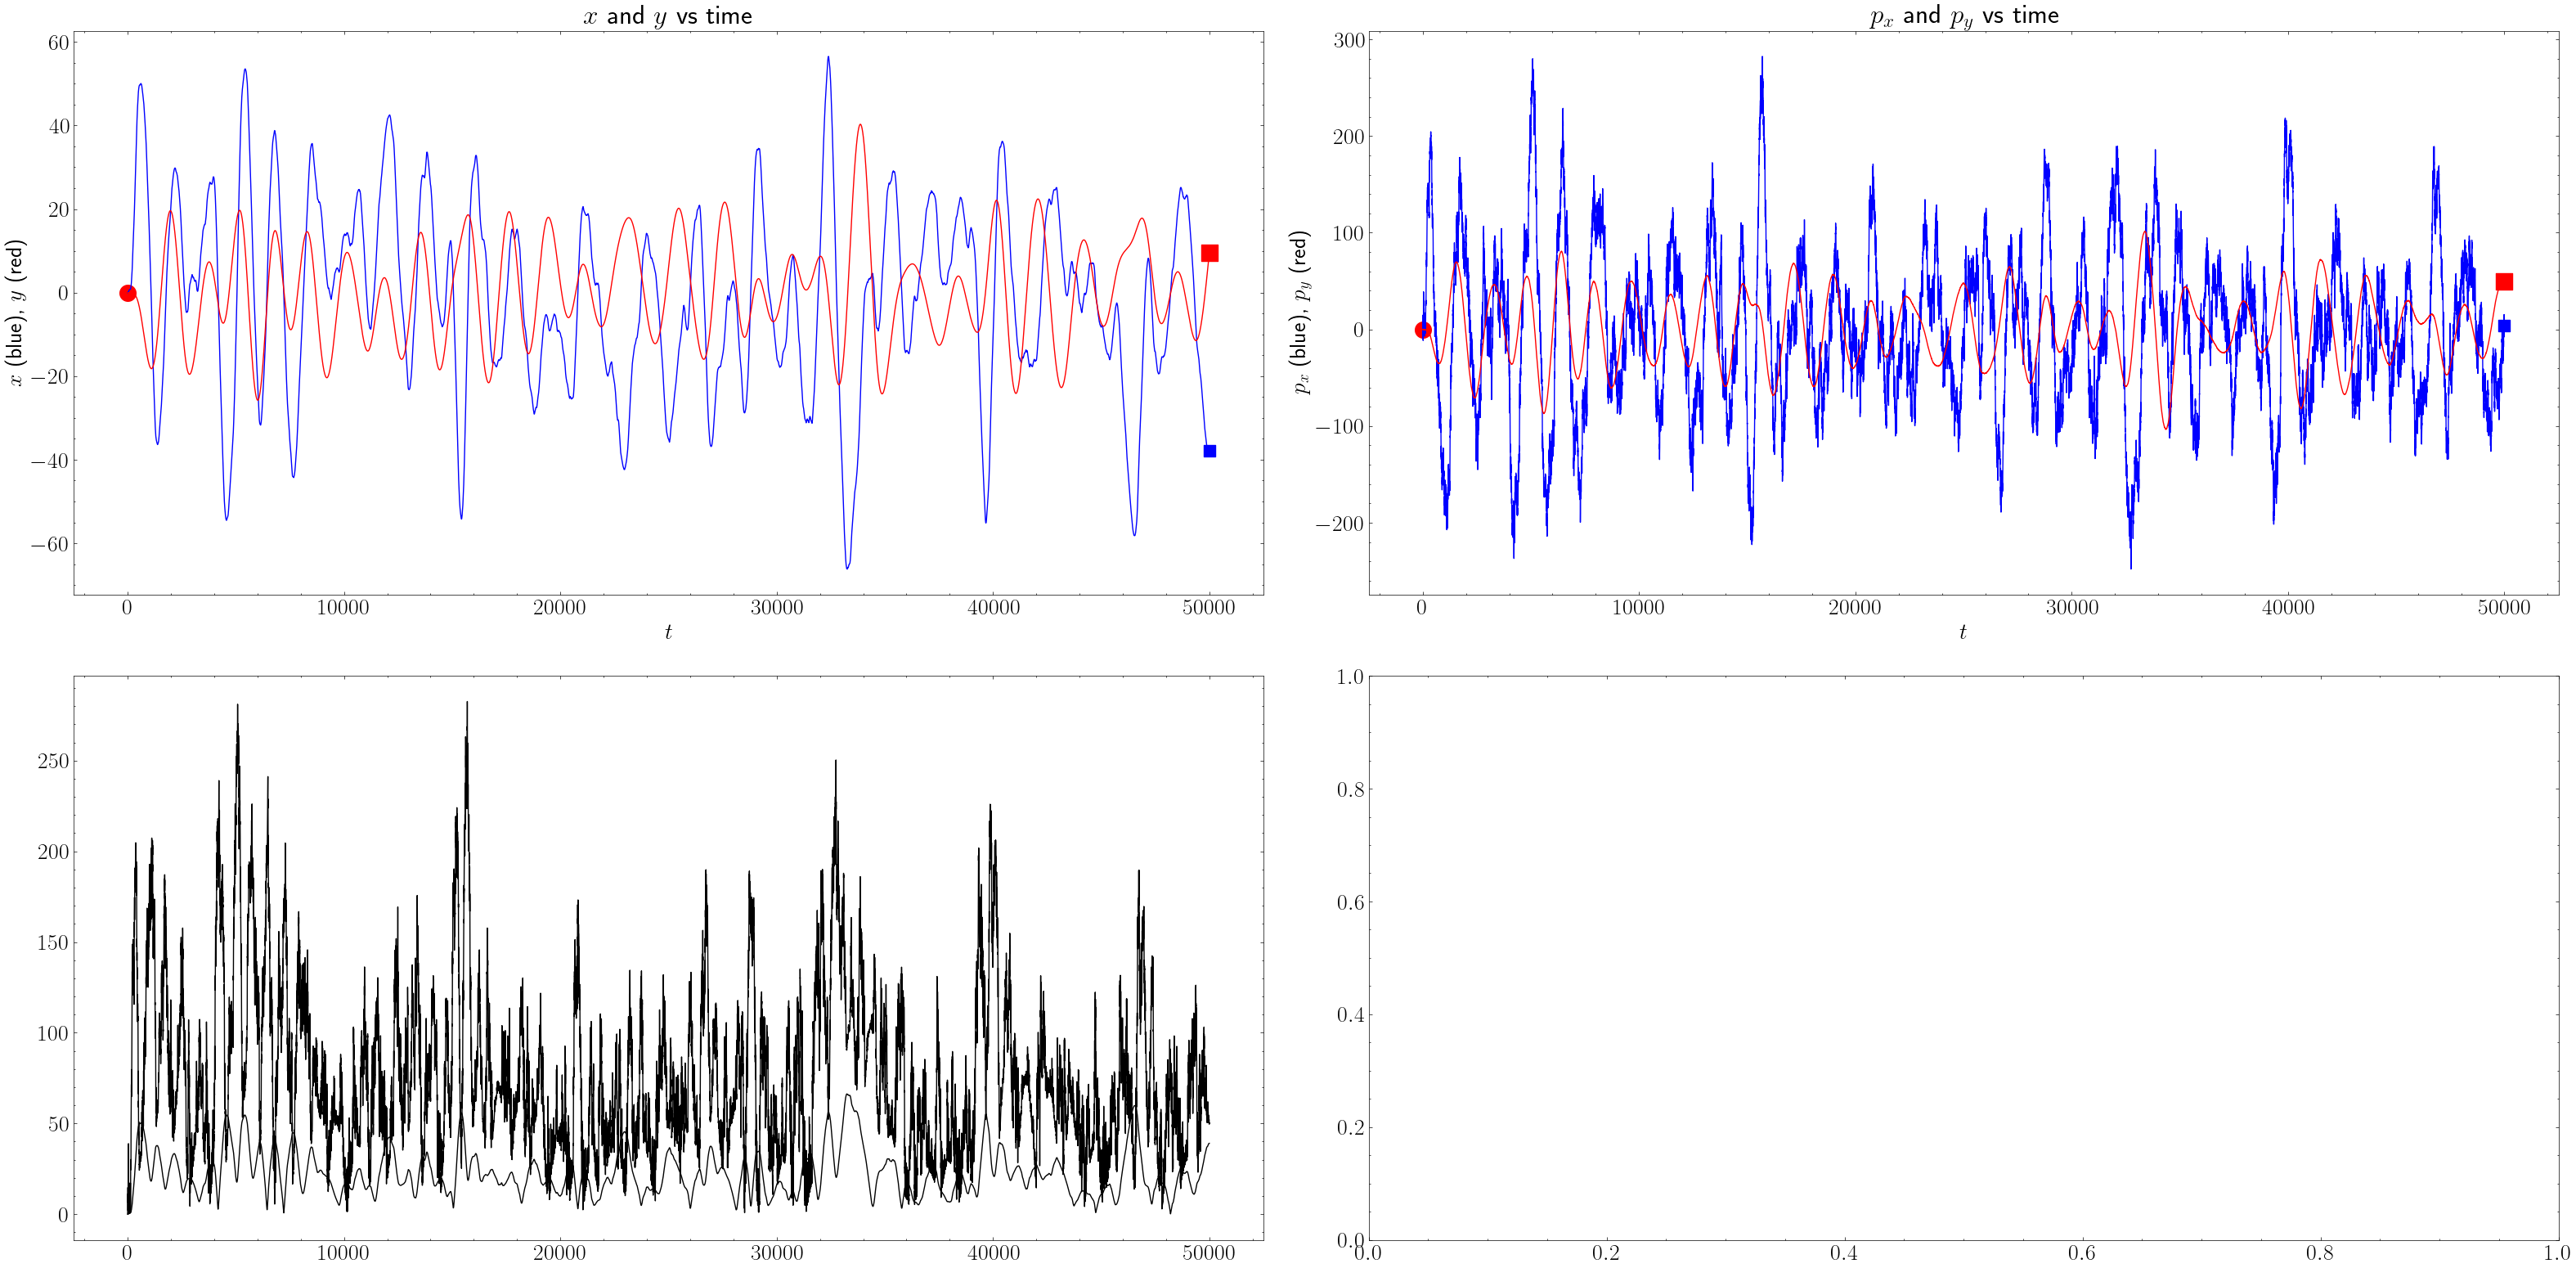

In [59]:
fig,axes = plt.subplots(2,2,figsize=(32,16), tight_layout=True)

ax = axes[0,0]
ax.plot(np.arange(0,nsteps), trajectory[:, 0], color='b', lw=1)
ax.plot(np.arange(0,nsteps), trajectory[:, 1], color='r', lw=1)
ax.scatter(0, trajectory[0, 0], color='b', s=100, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 0], marker='s',color='b', s=100, label='End')
ax.scatter(0, trajectory[0, 1], color='r', s=200, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 1],marker='s', color='r', s=200, label='End')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$ (blue), $y$ (red)')
ax.set_title(r'$x$ and $y$ vs time')

ax = axes[0,1]
ax.plot(np.arange(0,nsteps), trajectory[:, 2], color='b', lw=1)
ax.plot(np.arange(0,nsteps), trajectory[:, 3], color='r', lw=1)
ax.scatter(0, trajectory[0, 2], color='b', s=100, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 2],marker='s', color='b', s=100, label='End')
ax.scatter(0, trajectory[0, 3], color='r', s=200, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 3],marker='s', color='r', s=200, label='End')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$p_x$ (blue), $p_y$ (red)')
ax.set_title(r'$p_x$ and $p_y$ vs time')

ax = axes[1,0]
ax.plot(np.arange(0,nsteps), rtraj, color='k', lw=1)
ax.plot(np.arange(0,nsteps), prtraj, color='k', lw=1)

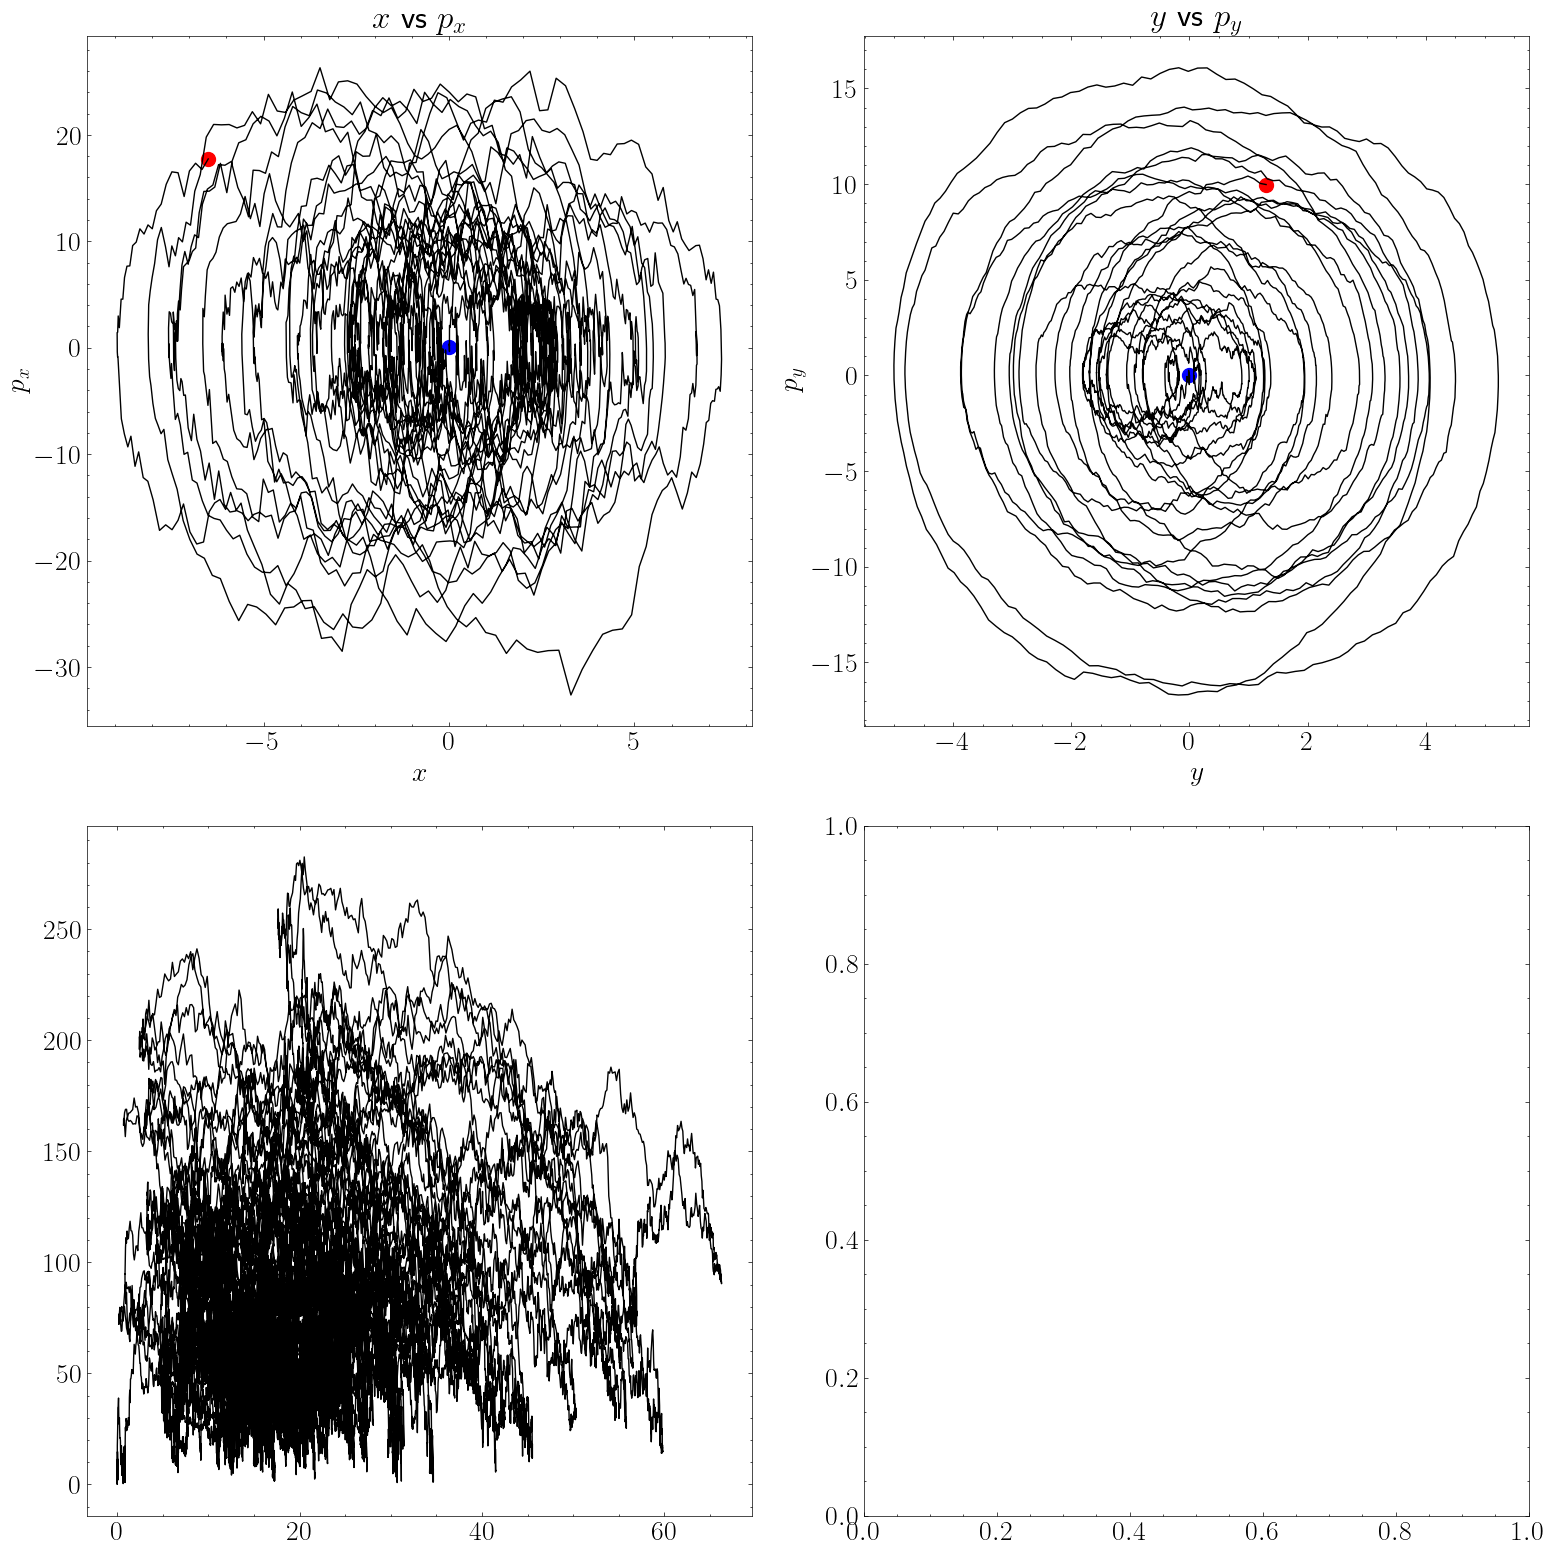

In [101]:
fig,axes = plt.subplots(2,2,figsize=(16,16), tight_layout=True)
ax = axes[0,0]
ax.plot( trajectory[:, 0], trajectory[:, 2], color='k', lw=1)
ax.scatter(trajectory[0, 0], trajectory[0, 2], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 0], trajectory[-1, 2], color='r', s=100, label='End')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_title(r'$x$ vs $p_x$')

ax = axes[0,1]
ax.plot( trajectory[:, 1], trajectory[:, 3], color='k', lw=1)
ax.scatter(trajectory[0, 1], trajectory[0, 3], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 1], trajectory[-1, 3], color='r', s=100, label='End')
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$p_y$')
ax.set_title(r'$y$ vs $p_y$')

ax = axes[1,0]
ax.plot(rtraj, prtraj, color='k', lw=1)

Text(0.5, 1.0, '$y$ and $p_y$ vs time')

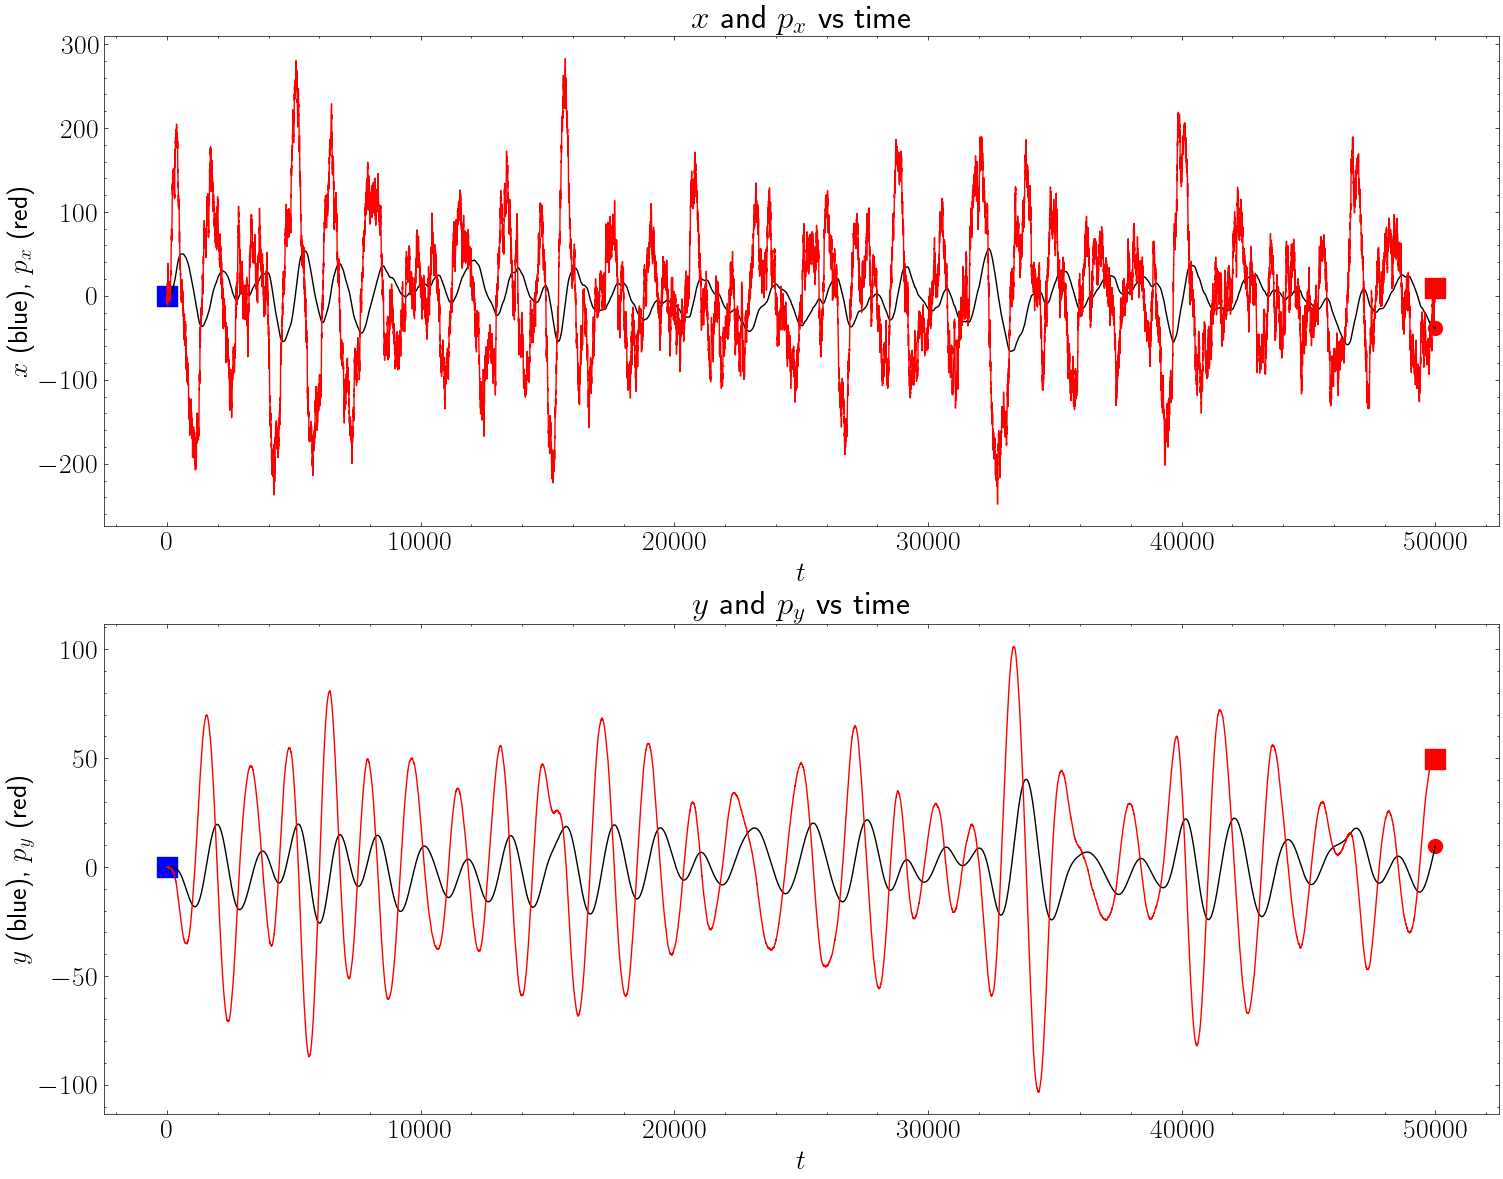

In [61]:
fig,axes = plt.subplots(2,1,figsize=(18, 14))
ax = axes[0]
ax.plot(np.arange(0,nsteps), trajectory[:, 0], color='black', lw=1)
ax.plot(np.arange(0,nsteps), trajectory[:, 2], color='r', lw=1)
ax.scatter(0, trajectory[0, 0], color='b', s=100, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 0], color='red', s=100, label='End')
ax.scatter(0, trajectory[0, 1],marker='s', color='b', s=200, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 1],marker='s', color='red', s=200, label='End')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$ (blue), $p_x$ (red)')
ax.set_title(r'$x$ and $p_x$ vs time')

ax = axes[1]
ax.plot(np.arange(0,nsteps), trajectory[:, 1], color='black', lw=1)
ax.plot(np.arange(0,nsteps), trajectory[:, 3], color='r', lw=1)
ax.scatter(0, trajectory[0, 1], color='b', s=100, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 1], color='red', s=100, label='End')
ax.scatter(0, trajectory[0, 3],marker='s', color='b', s=200, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 3],marker='s', color='red', s=200, label='End')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$y$ (blue), $p_y$ (red)')
ax.set_title(r'$y$ and $p_y$ vs time')

# fig.savefig('images/gyrator/ubgyrator_phase_DTlarge_pm_5_long.png', dpi=300)

In [62]:
%%time
ini = [1.0, .0, .0, 10.]
k = 10
m = 1.0
T = [.01, 100.]
eta = 1.0
alpha = 2.0
dt = 0.001
nsteps = 20000
L = np.zeros(nsteps) 
RR = 10000
for i in range(RR):
    trajectory = ubgyrator(k, alpha, m, T, eta, ini, dt, nsteps)
    print(f"Run {i+1}/{RR}")    
    L += angularmomentum(trajectory)
L /= RR

Run 1/10000
Run 2/10000
Run 3/10000
Run 4/10000
Run 5/10000
Run 6/10000
Run 7/10000
Run 8/10000
Run 9/10000
Run 10/10000
Run 11/10000
Run 12/10000
Run 13/10000
Run 14/10000
Run 15/10000
Run 16/10000
Run 17/10000
Run 18/10000
Run 19/10000
Run 20/10000
Run 21/10000
Run 22/10000
Run 23/10000
Run 24/10000
Run 25/10000
Run 26/10000
Run 27/10000
Run 28/10000
Run 29/10000
Run 30/10000
Run 31/10000
Run 32/10000
Run 33/10000
Run 34/10000
Run 35/10000
Run 36/10000
Run 37/10000
Run 38/10000
Run 39/10000
Run 40/10000
Run 41/10000
Run 42/10000
Run 43/10000
Run 44/10000
Run 45/10000
Run 46/10000
Run 47/10000
Run 48/10000
Run 49/10000
Run 50/10000
Run 51/10000
Run 52/10000
Run 53/10000
Run 54/10000
Run 55/10000
Run 56/10000
Run 57/10000
Run 58/10000
Run 59/10000
Run 60/10000
Run 61/10000
Run 62/10000
Run 63/10000
Run 64/10000
Run 65/10000
Run 66/10000
Run 67/10000
Run 68/10000
Run 69/10000
Run 70/10000
Run 71/10000
Run 72/10000
Run 73/10000
Run 74/10000
Run 75/10000
Run 76/10000
Run 77/10000
Run 78/1

In [90]:
def theoangularmomentum(k, u, eta, m, T):
    T1 = T[0]
    T2 = T[1]
    diffT = T2 - T1
    L = (eta*m*u*diffT)/(eta*k*eta + u*u*m )
    print(r"$\gamma$ = "+str(eta))
    print(r"$k$ = "+str(k))
    print(r"$u$ = "+str(u))
    print(r"$m$ = "+str(m))
    print(r"$T_x$ = "+str(T1))
    print(r"$T_y$ = "+str(T2))
    return L
    

In [58]:
l = theoangularmomentum(k, alpha, eta, m, T)

l

14.284285714285714

Text(0.5, 1.0, '$L$ vs $t$ with : $k=$10, $\\alpha=$2.0, $m=$1.0, $T_x=$0.01, $T_y=$100.0, $\\eta=$1.0')

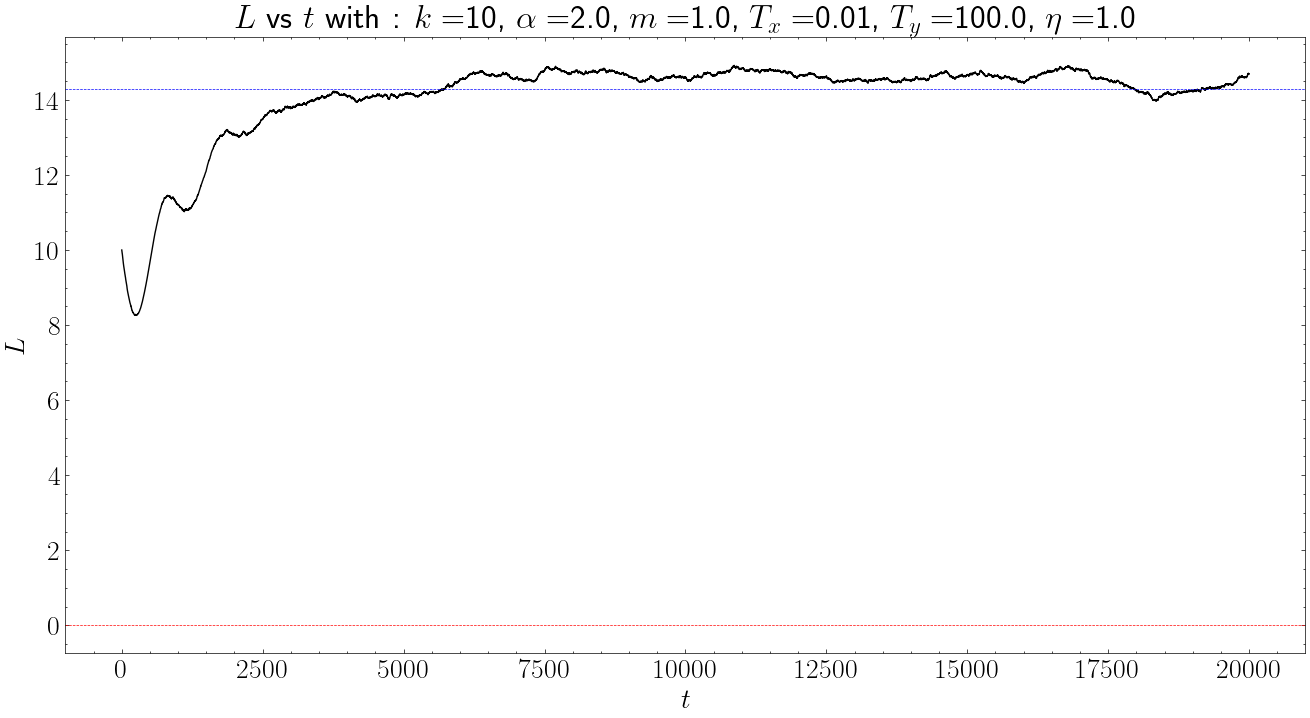

In [63]:
plt.figure(figsize=(16,8))
# plt.plot( np.arange(0,nsteps), angularmomentum(trajectory), color='k', lw=1)
# plt.scatter(0, angularmomentum(trajectory)[0], color='b', s=100, label='Start')

# plt.scatter(nsteps-1, angularmomentum(trajectory)[-1], color='r', s=100, label='End')
plt.plot( np.arange(0,nsteps), L, color='k', lw=1)
plt.axhline(0, color='r', lw=0.5, ls='--')
plt.axhline(l, color='b', lw=0.5, ls='--', label='Theoretical L')
plt.xlabel(r'$t$')
plt.ylabel(r'$L$')
plt.title(r'$L$ vs $t$ with : $k=$'+str(k)+r', $\alpha=$'+str(alpha)+r', $m=$'+str(m)+r', $T_x=$'+str(T[0])+r', $T_y=$'+str(T[1])+r', $\eta=$'+str(eta))
# plt.savefig('images/gyrator/udgyrator_LDTlarge_1_long.png', dpi=300)

In [126]:
# import numpy as np
import scipy.linalg
# from numba import njit

def exact_ubgyrator(k, alpha, m, T, eta, ini, dt, nsteps):
    """
    Exact simulation of the underdamped Brownian gyrator.
    
    Parameters
    ----------
    k : float
        Stiffness of the isotropic harmonic part.
    alpha : float
        Coupling strength (off‑diagonal potential term).
    m : float
        Mass of the particle.
    T : array_like (2,)
        Temperatures [Tx, Ty] of the two heat baths.
    eta : float
        Friction coefficient (same for both directions).
    ini : array_like (4,)
        Initial state [x, y, vx, vy].
    dt : float
        Time step.
    nsteps : int
        Number of steps.

    Returns
    -------
    traj : ndarray, shape (nsteps, 4)
        Trajectory containing [x, y, vx, vy] at each time step.
    """
    # --- Build the drift matrix A and diffusion matrix B ---
    A = np.zeros((4, 4))
    A[0, 2] = 1.0 / m
    A[1, 3] = 1.0 / m
    A[2, 0] = -k
    A[2, 1] = -alpha
    A[2, 2] = -eta / m
    A[3, 0] = -alpha
    A[3, 1] = -k
    A[3, 3] = -eta / m

    B = np.zeros((4, 4))
    B[2, 2] = np.sqrt(2.0 * T[0] * eta) / m
    B[3, 3] = np.sqrt(2.0 * T[1] * eta) / m

    # --- Precompute the exact discrete-time matrices ---
    # 1. Matrix exponential of A * dt
    M = scipy.linalg.expm(A * dt)

    # 2. Stationary covariance of the continuous process (solve Lyapunov equation)
    #    A @ Sigma_inf + Sigma_inf @ A.T + B @ B.T = 0
    Q = B @ B.T
    Sigma_inf = scipy.linalg.solve_continuous_lyapunov(A, -Q)

    # 3. Covariance of the discrete noise: Sigma_zeta = Sigma_inf - M @ Sigma_inf @ M.T
    Sigma_zeta = Sigma_inf - M @ Sigma_inf @ M.T

    # 4. Cholesky factor of Sigma_zeta (for fast noise generation)
    #    Add a tiny diagonal to guard against near-singularity
    try:
        L_zeta = np.linalg.cholesky(Sigma_zeta)
    except np.linalg.LinAlgError:
        eps = 1e-12
        L_zeta = np.linalg.cholesky(Sigma_zeta + eps * np.eye(4))

    # --- JIT-compiled simulation loop ---
    # @njit
   

    return M , L_zeta

@njit
def simulate(ini, M, L_zeta, nsteps):
    traj = np.zeros((nsteps, 4))
    ini = np.array(ini)
    traj[0] = ini
    state = ini.copy()
    for i in range(1, nsteps):
        xi = np.random.normal(0,1,(4,))              # standard normal vector
        noise = L_zeta @ xi
        state = M @ state + noise
        traj[i] = state
    return traj

In [144]:
# Example parameters
k = 1.0
alpha = 0.5
m = 1.0
T = [1.0, 2.0]       # different temperatures
eta = 1.0
ini = [0.0, 0.0, 0.0, 0.0]
dt = 0.01
nsteps = 2000

M, L_zeta = exact_ubgyrator(k, alpha, m, T, eta, ini, dt, nsteps)

traj = simulate(ini, M, L_zeta, nsteps)

# Extract positions and velocities
x = traj[:, 0]
y = traj[:, 1]
vx = traj[:, 2]
vy = traj[:, 3]

# Compute angular momentum (correct: m * (x*vy - y*vx))
L_sim = m * np.mean(x * vy - y * vx)
print(f"Simulated mean angular momentum: {L_sim:.6f}")

# Compare with theoretical value (your function)
L_theo = theoangularmomentum(k, alpha, eta, m, T)
print(f"Theoretical value: {L_theo:.6f}")
L = np.zeros(nsteps) 


Simulated mean angular momentum: -0.178510
$\gamma$ = 1.0
$k$ = 1.0
$u$ = 0.5
$m$ = 1.0
$T_x$ = 1.0
$T_y$ = 2.0
Theoretical value: 0.400000


In [ ]:
for i in range(RR):
    traj = simulate(ini, M, L_zeta, nsteps)
    print(f"Run {i+1}/{RR}")    
    L += angularmomentum(traj)
L /= RR


Run 1/10000
Run 2/10000
Run 3/10000
Run 4/10000
Run 5/10000
Run 6/10000
Run 7/10000
Run 8/10000
Run 9/10000
Run 10/10000
Run 11/10000
Run 12/10000
Run 13/10000
Run 14/10000
Run 15/10000
Run 16/10000
Run 17/10000
Run 18/10000
Run 19/10000
Run 20/10000
Run 21/10000
Run 22/10000
Run 23/10000
Run 24/10000
Run 25/10000
Run 26/10000
Run 27/10000
Run 28/10000
Run 29/10000
Run 30/10000
Run 31/10000
Run 32/10000
Run 33/10000
Run 34/10000
Run 35/10000
Run 36/10000
Run 37/10000
Run 38/10000
Run 39/10000
Run 40/10000
Run 41/10000
Run 42/10000
Run 43/10000
Run 44/10000
Run 45/10000
Run 46/10000
Run 47/10000
Run 48/10000
Run 49/10000
Run 50/10000
Run 51/10000
Run 52/10000
Run 53/10000
Run 54/10000
Run 55/10000
Run 56/10000
Run 57/10000
Run 58/10000
Run 59/10000
Run 60/10000
Run 61/10000
Run 62/10000
Run 63/10000
Run 64/10000
Run 65/10000
Run 66/10000
Run 67/10000
Run 68/10000
Run 69/10000
Run 70/10000
Run 71/10000
Run 72/10000
Run 73/10000
Run 74/10000
Run 75/10000
Run 76/10000
Run 77/10000
Run 78/1

Text(0.5, 1.0, '$L$ vs $t$ with : $k=$1.0, $\\alpha=$0.5, $m=$1.0, $T_x=$1.0, $T_y=$2.0, $\\eta=$1.0')

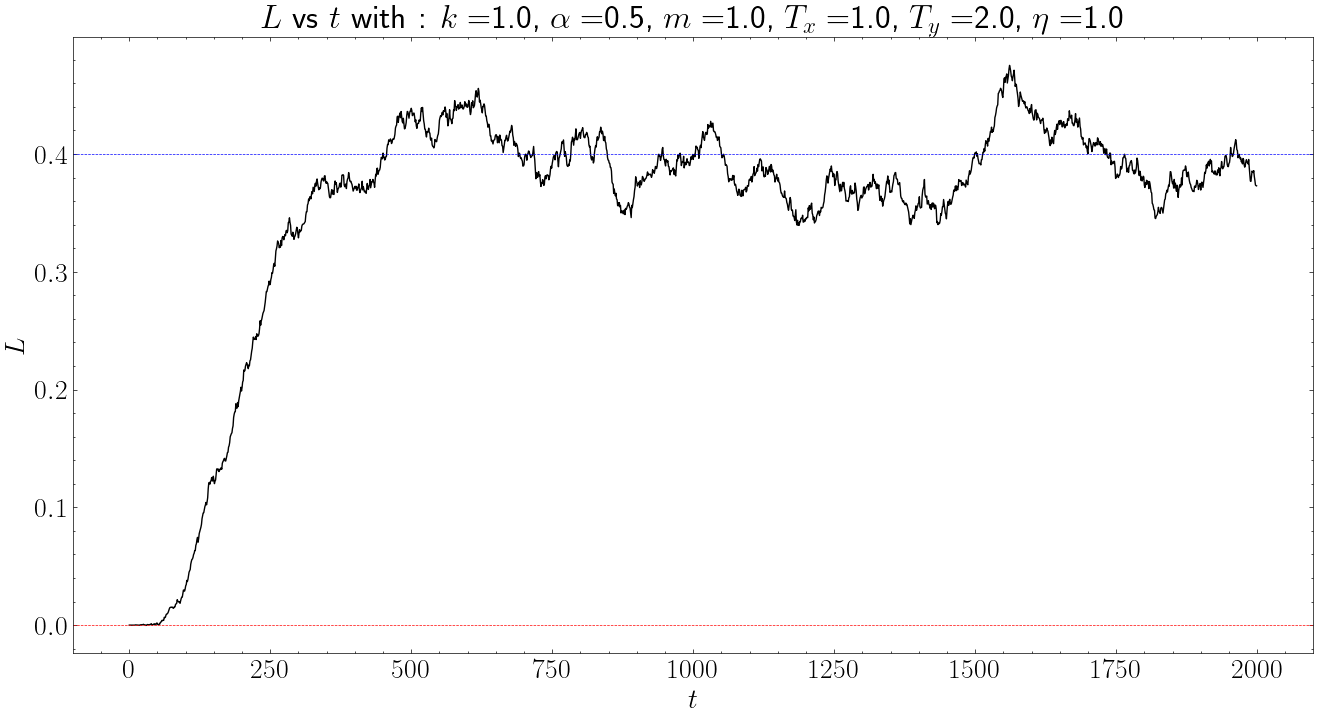

In [148]:
plt.figure(figsize=(16,8))
# plt.plot( np.arange(0,nsteps), angularmomentum(trajectory), color='k', lw=1)
# plt.scatter(0, angularmomentum(trajectory)[0], color='b', s=100, label='Start')

# plt.scatter(nsteps-1, angularmomentum(trajectory)[-1], color='r', s=100, label='End')
plt.plot( np.arange(0,nsteps), L, color='k', lw=1)
plt.axhline(0, color='r', lw=0.5, ls='--')
plt.axhline(L_theo, color='b', lw=0.5, ls='--', label='Theoretical L')
plt.xlabel(r'$t$')
plt.ylabel(r'$L$')
plt.title(r'$L$ vs $t$ with : $k=$'+str(k)+r', $\alpha=$'+str(alpha)+r', $m=$'+str(m)+r', $T_x=$'+str(T[0])+r', $T_y=$'+str(T[1])+r', $\eta=$'+str(eta))
# plt.savefig('images/gyrator/udgyrator_LDTlarge_1_long.png', dpi=300)

Text(0, 0.5, 'Y')

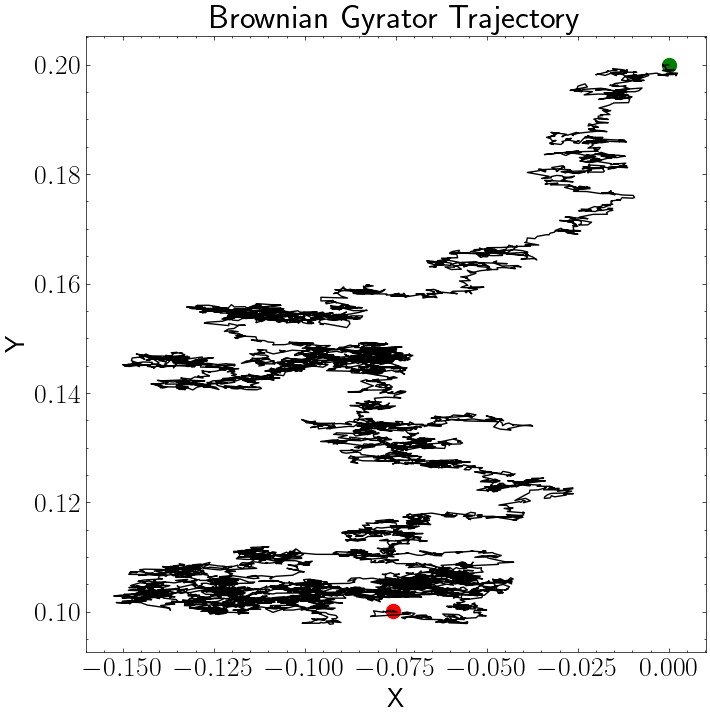

In [90]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x, y, color='k')
ax.scatter(x[0], y[0], color='green', s=100, label='Start')
ax.scatter(x[-1], y[-1], color='red', s=100, label='End')
ax.set_title('Brownian Gyrator Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [151]:
nsteps=2000
k = 1.999
alpha = 0.99
dt=0.003
# T1 = [0,0]
T = [100.01,.002]
ini = [0.0, 0.0]
trajectory = bgyrator(k, alpha, T, eta, ini, dt, nsteps)
x, y = np.mgrid[-1.5:1.5:.01,     -1.5:1.5:.01]
potential = 0.5 * (k*(x**2 + y**2)) + alpha*x*y
# plt.contour(x, y, potential, levels=3, cmap='binary')
time = np.arange(0, nsteps*dt, dt)

# Determine plot limits based on trajectory with some padding
x_min, x_max = trajectory[:, 0].min(), trajectory[:, 0].max()
y_min, y_max = trajectory[:, 1].min(), trajectory[:, 1].max()
padding = 0.06
x_range = (x_min - 2*padding, x_max + 2*padding)
y_range = (y_min - padding, y_max + padding)

# Generate potential contour data
X, Y, Z = generate_potential_grid(k, alpha, x_range, y_range, n_points=200)


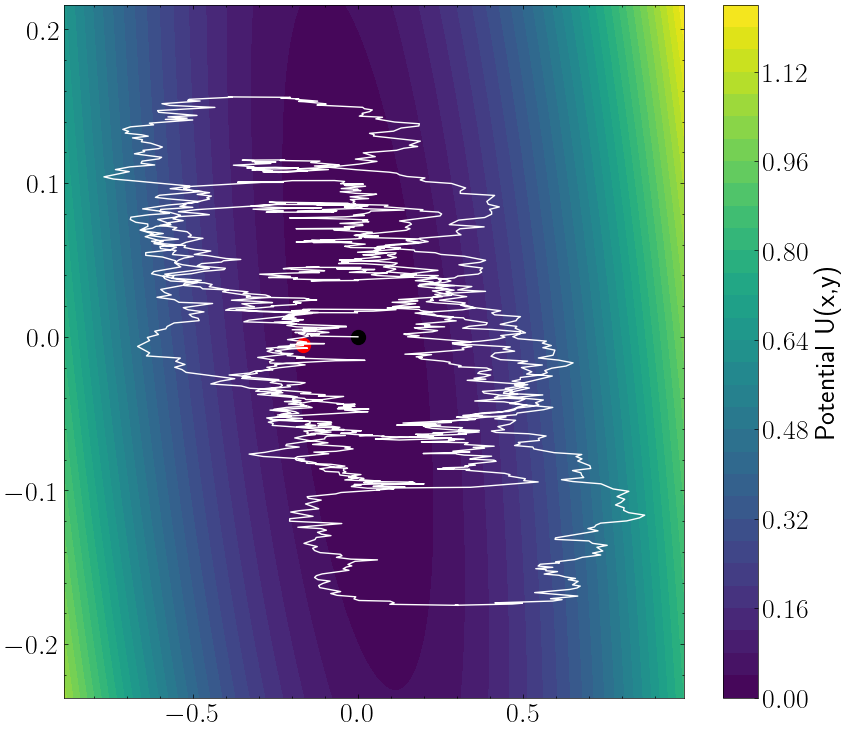

In [152]:
plt.figure(figsize=(10, 9))
contour = plt.contourf(X, Y, Z, levels=30, cmap='viridis')
plt.colorbar(contour, label='Potential U(x,y)')
plt.plot(trajectory[:, 0], trajectory[:, 1], color='white', lw=1)
plt.scatter(trajectory[0, 0], trajectory[0, 1], color='black', s=100, label='Start')
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', s=100, label='End')

In [63]:
import matplotlib.style as mplstyle
mplstyle.use('fast')


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



Generating simple animation...
Frame 1/2000
Frame 1/2000
Frame 1/2000
Frame 1/2000
Frame 2/2000
Frame 3/2000
Frame 4/2000
Frame 5/2000
Frame 6/2000
Frame 7/2000
Frame 8/2000
Frame 9/2000
Frame 10/2000
Frame 11/2000
Frame 12/2000
Frame 13/2000
Frame 14/2000
Frame 15/2000
Frame 16/2000
Frame 17/2000
Frame 18/2000
Frame 19/2000
Frame 20/2000
Frame 21/2000
Frame 22/2000
Frame 23/2000
Frame 24/2000
Frame 25/2000
Frame 26/2000
Frame 27/2000
Frame 28/2000
Frame 29/2000
Frame 30/2000
Frame 31/2000
Frame 32/2000
Frame 33/2000
Frame 34/2000
Frame 35/2000
Frame 36/2000
Frame 37/2000
Frame 38/2000
Frame 39/2000
Frame 40/2000
Frame 41/2000
Frame 42/2000
Frame 43/2000
Frame 44/2000
Frame 45/2000
Frame 46/2000
Frame 47/2000
Frame 48/2000
Frame 49/2000
Frame 50/2000
Frame 51/2000
Frame 52/2000
Frame 53/2000
Frame 54/2000
Frame 55/2000
Frame 56/2000
Frame 57/2000
Frame 58/2000
Frame 59/2000
Frame 60/2000
Frame 61/2000
Frame 62/2000
Frame 63/2000
Frame 64/2000
Frame 65/2000
Frame 66/2000
Frame 67/2000


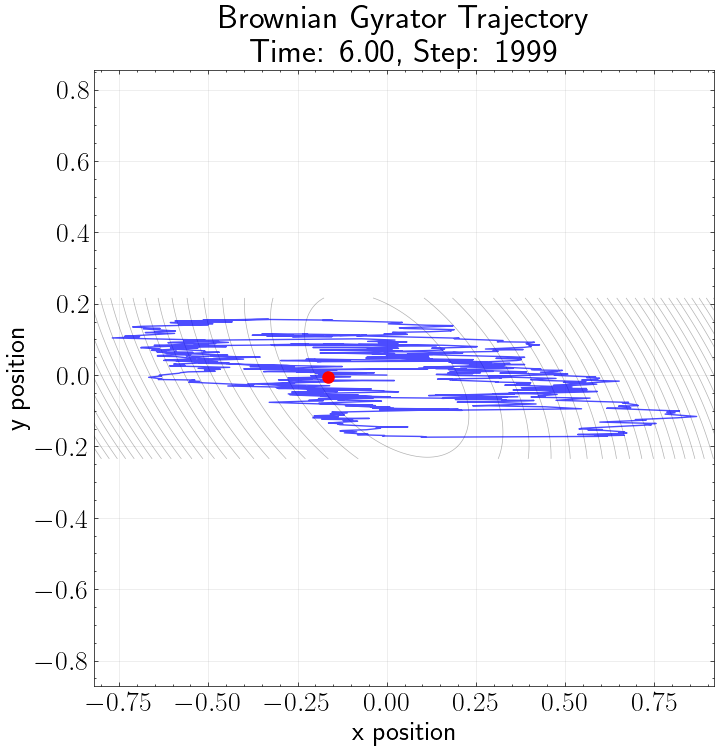

In [153]:

# Create the figure and axis
print("\nGenerating simple animation...")
fig_simple, ax_simple = plt.subplots(figsize=(8, 8))
ax_simple.set_xlim(trajectory[:, 0].min() - 0.05, trajectory[:, 0].max() + 0.05)
ax_simple.set_ylim(trajectory[:, 1].min() - 0.05, trajectory[:, 1].max() + 0.05)
ax_simple.set_xlabel('x position')
ax_simple.set_ylabel('y position')
contour_lines_simple = ax_simple.contour(X, Y, Z, levels=30, colors='black', alpha=0.3, linewidths=0.5)
ax_simple.set_title('Brownian Gyrator Trajectory Animation')
ax_simple.grid(True, alpha=0.3)
ax_simple.set_aspect('equal', adjustable='datalim')

line, = ax_simple.plot([], [], 'b-', alpha=0.7, lw=1)
point, = ax_simple.plot([], [], 'ro', markersize=8)

def update_simple(frame):
    line.set_data(trajectory[:frame+1, 0], trajectory[:frame+1, 1])
    point.set_data([trajectory[frame, 0]], [trajectory[frame, 1]])
    ax_simple.set_title(f'Brownian Gyrator Trajectory\nTime: {time[frame]:.2f}, Step: {frame}')
    print(f'Frame {frame+1}/{nsteps}')
    return line, point

ani_simple = FuncAnimation(fig_simple, update_simple, frames=nsteps, interval=20, blit=True)
ani_simple.save('images/gyrator/bg_anim_LargeDT_u0_test2.mp4', writer='ffmpeg', dpi=300)



In [154]:
print("\n" + "="*60)
print("POTENTIAL INFORMATION:")
print("="*60)
print(f"Potential function: U(x,y) = (1/2)*{k}*(x² + y²) + {alpha}*x*y")
print(f"Minimum at: (0, 0)")
print(f"Potential at origin: U(0,0) = 0")
print(f"Potential curvature:")
print(f"  ∂²U/∂x² = k = {k}")
print(f"  ∂²U/∂y² = k = {k}")
print(f"  ∂²U/∂x∂y = α = {alpha}")
print(f"Eigenvalues of Hessian: {k - alpha}, {k + alpha}")
print("="*60)


POTENTIAL INFORMATION:
Potential function: U(x,y) = (1/2)*1.999*(x² + y²) + 0.99*x*y
Minimum at: (0, 0)
Potential at origin: U(0,0) = 0
Potential curvature:
  ∂²U/∂x² = k = 1.999
  ∂²U/∂y² = k = 1.999
  ∂²U/∂x∂y = α = 0.99
Eigenvalues of Hessian: 1.0090000000000001, 2.989


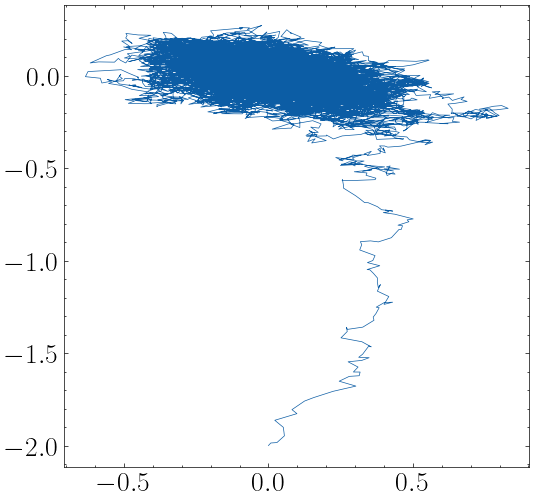

In [49]:
plt.figure(figsize=(6,6))
plt.plot(x, y, lw=0.5)

In [61]:
RUNS = 10000
xyruns = np.zeros((nsteps, 2, RUNS))
for i in range(RUNS):
    ini = np.random.uniform(-0.2,0.2,2)
    xyruns[:,:,i] = bgyrator(k, alpha, T, eta, ini, dt, nsteps)


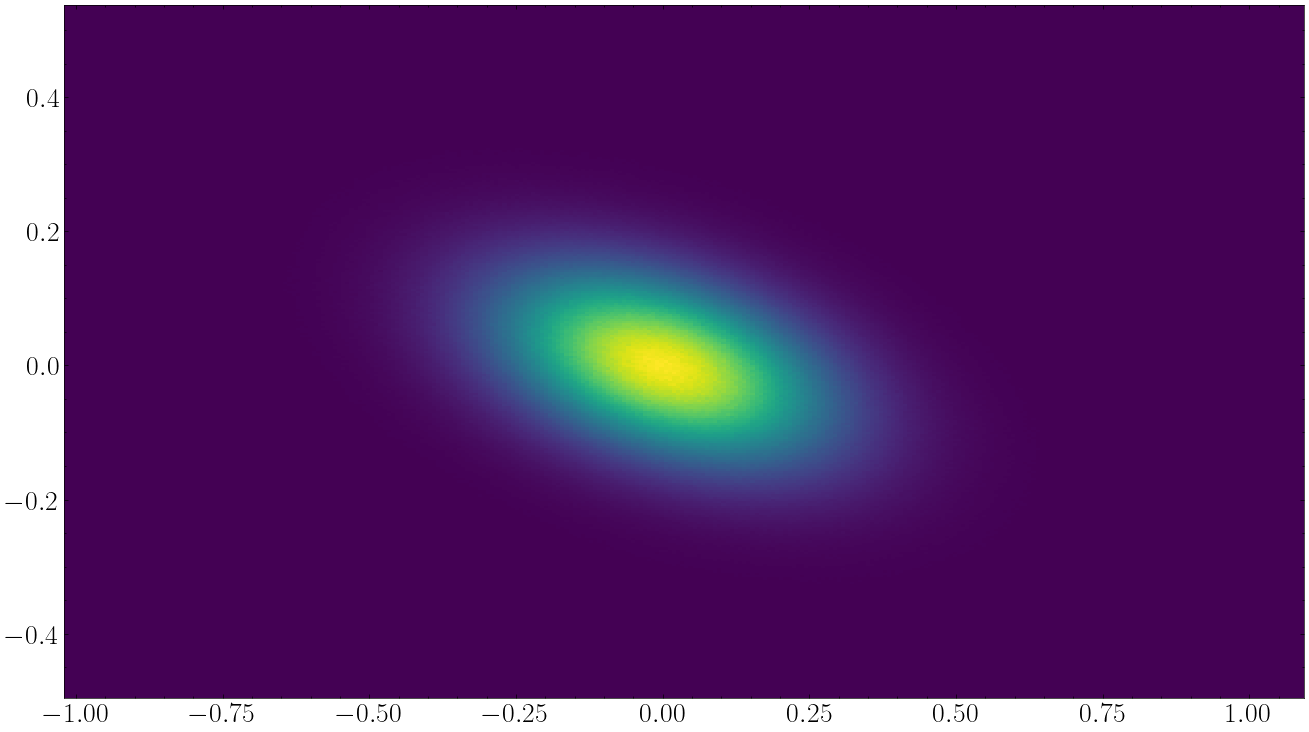

In [57]:
ct = 2000
plt.figure(figsize=(16,9))
counts,ybins,xbins, image= plt.hist2d(xyruns[ct:,0,:].flatten(), xyruns[ct:,1,:].flatten(), bins=300)


In [62]:
mean  = [0,0]

def C_xx_matrix(k, alpha, T):
    """
    Compute the C_xx matrix.

    Parameters
    ----------
    k : float
        Scalar k
    alpha : float
        Scalar alpha (replaces u)
    T : array-like of length 2
        T[0] = T1, T[1] = T2

    Returns
    -------
    2x2 numpy array
    """

    T1 = T[0]
    T2 = T[1]

    prefactor = 1.0 / (2 * k * (k**2 - alpha**2))

    M = np.array([
        [2*T1*k**2 + (T2 - T1)*alpha**2,  -(T1 + T2)*k*alpha],
        [-(T1 + T2)*k*alpha,              2*T2*k**2 + (T1 - T2)*alpha**2]
    ])

    return prefactor * M
covmat = C_xx_matrix(k, alpha, T)

0.008527367277158976


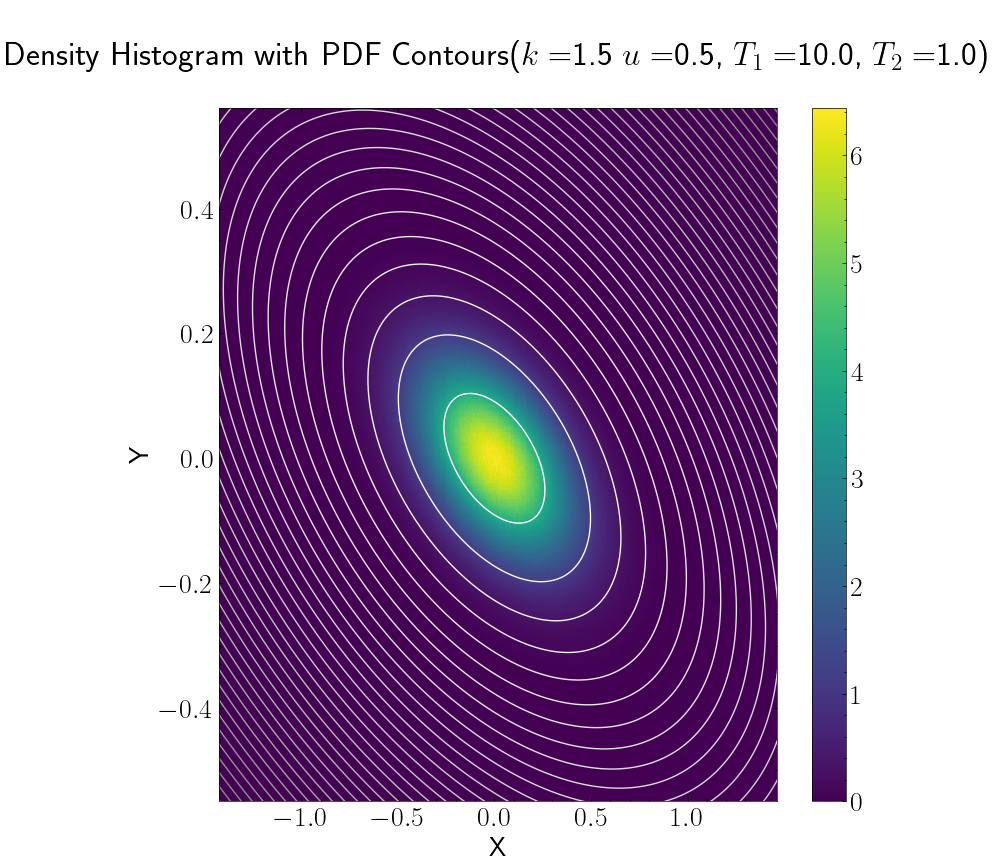

In [64]:
from scipy.stats import multivariate_normal

x, y = np.mgrid[-1.5:1.5:.01,     -1.5:1.5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean, covmat)


# fig2,ax2 = plt.subplots(1,1,figsize=(16,9))
plt.figure(figsize=(9,9))
print(rv.pdf(pos)[0,0])

# # ax = ax2[0]
# ax.contourf(x, y, rv.pdf(pos), norm ="linear")
potential = 0.5 * (k*(x**2 + y**2)) + alpha*x*y

potential = 0.5 * (k*(x**2 + y**2)) + alpha*x*y
plt.contour(x, y, rv.pdf(pos), levels=70, cmap='gray',zorder=2)
counts,ybins,xbins, image= plt.hist2d(xyruns[ct:,0,:].flatten(), xyruns[ct:,1,:].flatten(), bins=300, density=True, cmap = 'viridis')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('\n Density Histogram with PDF Contours('+r"$k = $"+str(k)+r" $u = $"+str(alpha)+r", $T_1=$"+str(T[0])+r", $T_2=$"+str(T[1])+")\n")
plt.savefig('images/gyrator/gyrator_density11.png', dpi=300, bbox_inches='tight')
# plt.xlim(-1,1)
# plt.ylim(-1,1)

# plt.imshow(counts)
# plt.contour(x, y, potential, levels=3, cmap='binary')



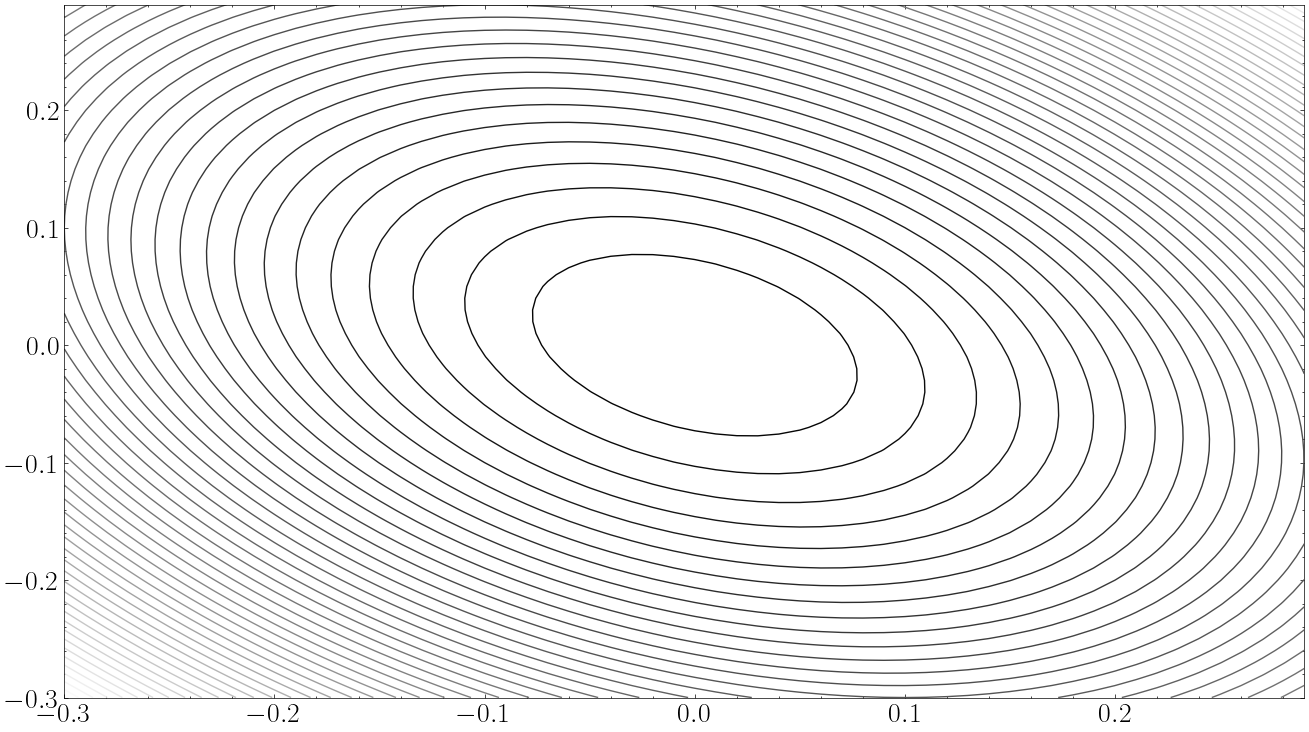

In [ ]:
plt.figure(figsize=(16,9))
x,y = np.mgrid[-0.3:0.3:.01, -0.3:0.3:.01]
pos = np.dstack((x, y))
